<a href="https://colab.research.google.com/github/AubLambert/FraudDetection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Import Libraries

In [ ]:
!pip install xgboost

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn

In [ ]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# Scipy
from scipy.stats import chi2_contingency
from scipy.stats import mode
from scipy.stats import skew

# Sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay, average_precision_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Light GBM
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

# Step 1: Basic Analysis

## Train Set

### Import Data

In [ ]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Optional: Set the width to avoid line breaks
pd.set_option('display.width', None)

df = pd.read_csv('fraudTrain.csv', on_bad_lines='warn')
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [ ]:
df = df.drop('Unnamed: 0', axis=1)

### Descriptive Statistics

In [ ]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [ ]:
df.shape

(1296675, 22)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [ ]:
df.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [ ]:
df.select_dtypes(include=['int64', 'float64']).nunique()

,0
cc_num,983
amt,52928
zip,970
lat,968
long,969
city_pop,879
unix_time,1274823
merch_lat,1247805
merch_long,1275745
is_fraud,2


In [ ]:
df.select_dtypes(include=['object', 'category']).nunique()

,0
trans_date_trans_time,1274791
merchant,693
category,14
first,352
last,481
gender,2
street,983
city,894
state,51
job,494


## Test Set

### Import Data

In [ ]:
df_test = pd.read_csv('fraudTest.csv', on_bad_lines='warn')
df_test

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [ ]:
df_test = df_test.drop('Unnamed: 0', axis=1)

### Descriptive Statistics

In [ ]:
df_test.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,1.800429e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,3.521417e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,4.635331e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,4.992346e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


In [ ]:
df_test.shape

(555719, 22)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [ ]:
df_test.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [ ]:
df_test.select_dtypes(include=['int64', 'float64']).nunique()

,0
cc_num,924
amt,37256
zip,912
lat,910
long,910
city_pop,835
unix_time,544760
merch_lat,546490
merch_long,551770
is_fraud,2


In [ ]:
df_test.select_dtypes(include=['object', 'category']).nunique()

,0
trans_date_trans_time,544760
merchant,693
category,14
first,341
last,471
gender,2
street,924
city,849
state,50
job,478


# Step 2: EDA

In [ ]:
# Create a copy for EDA
df_viz = df.copy()

## Data Transformation for Vizualization

### Fraud Rate

In [ ]:
fraud_percent = (df['is_fraud'] == 1).sum()/(df.shape[0])

print(f"Fraud Percentage: {fraud_percent * 100:.5f}%")

Fraud Percentage: 0.57887%


### Correlation

#### Numerical correlation

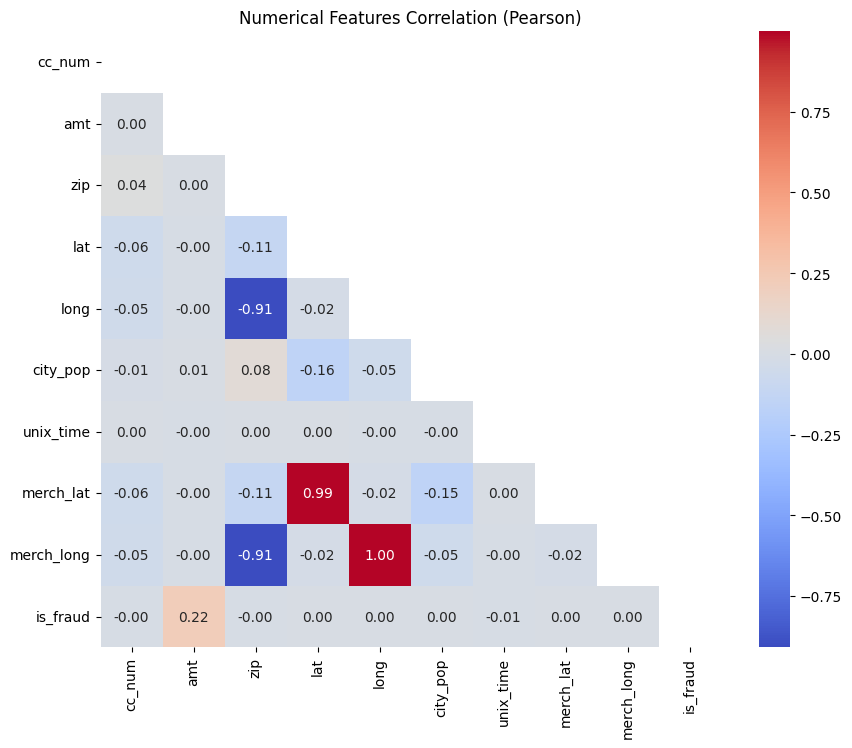

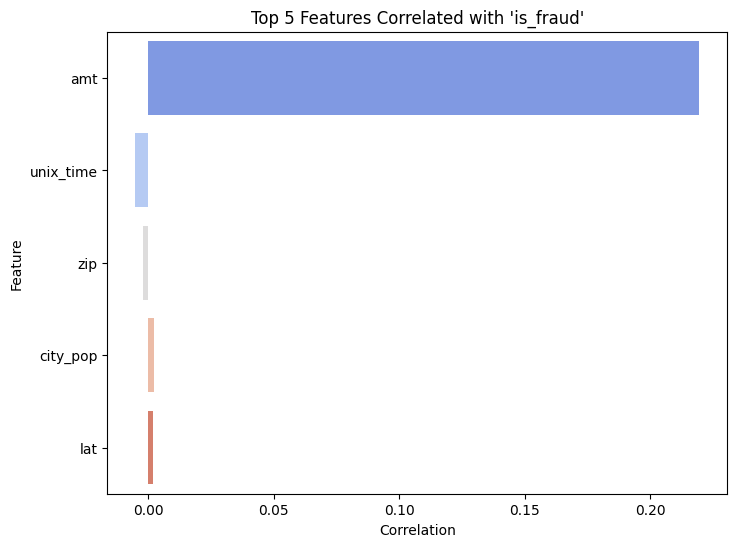

In [ ]:
def num_corr(df, target="is_fraud", n=5):
    # Select numerical columns
    num_cols = df.select_dtypes(include=['int32', 'int64', 'float64'])

    # Pearson correlation matrix
    corr_num = num_cols.corr()

    # If target not in numerical columns
    if target not in corr_num.columns:
        raise ValueError(f"Target '{target}' not found among numerical columns.")

    # Extract correlations with target
    corr_target = corr_num[target].drop(target)  # drop self-correlation

    # Get top n absolute correlations
    top_features = corr_target.abs().sort_values(ascending=False).head(n)
    top_features_signed = corr_target.loc[top_features.index]  # keep sign for bar chart

    # --- Plot heatmap of all correlations ---
    mask = np.triu(np.ones_like(corr_num, dtype=bool))
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_num, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    plt.title("Numerical Features Correlation (Pearson)")
    plt.show()

    # --- Plot bar chart of top n correlations ---
    plt.figure(figsize=(8,6))
    sns.barplot(x=top_features_signed.values, y=top_features_signed.index, palette="coolwarm")
    plt.title(f"Top {n} Features Correlated with '{target}'")
    plt.xlabel("Correlation")
    plt.ylabel("Feature")
    plt.show()

num_corr(df_viz)

#### Categorical correlation

In [ ]:
df_viz_samp = df_viz.drop(["trans_date_trans_time", "dob", "trans_num"], axis=1)

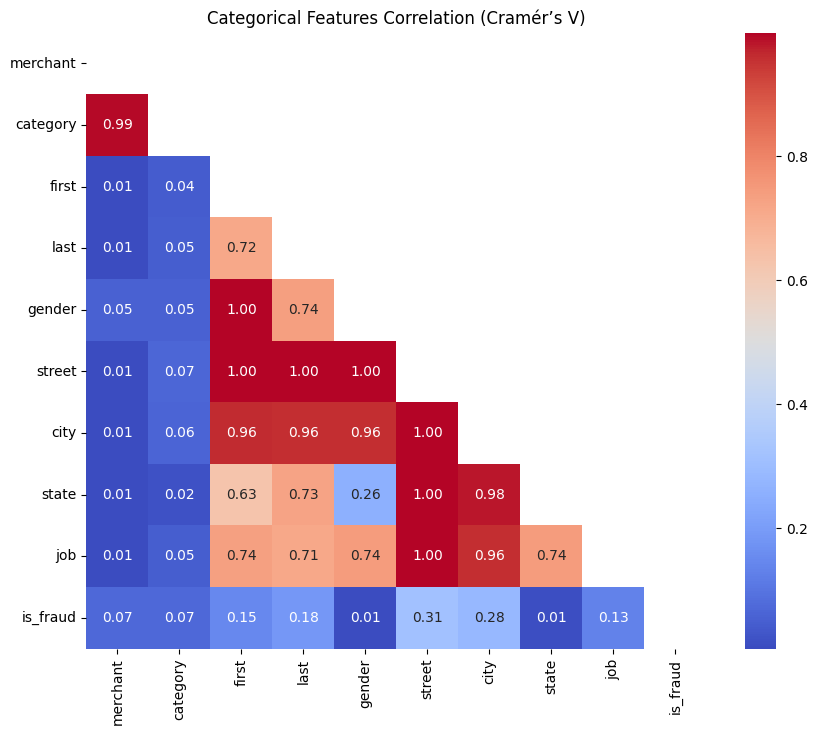

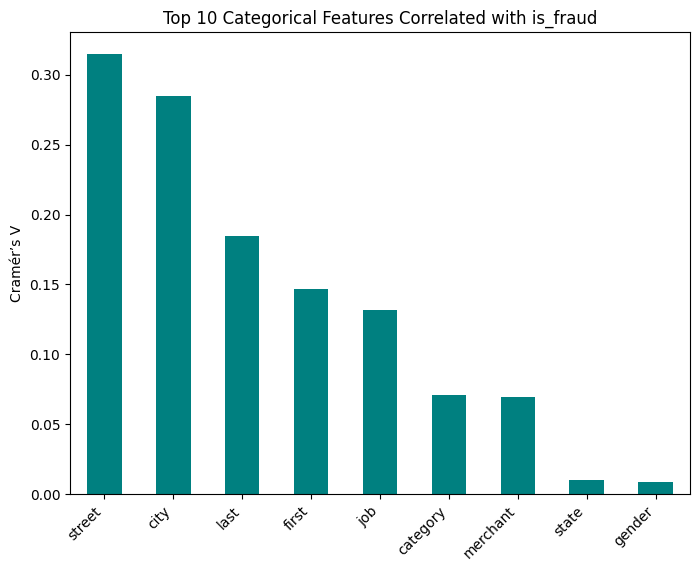

In [ ]:
def cat_corr(df, n=10):
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n_obs = confusion_matrix.sum().sum()
        phi2 = chi2 / n_obs
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n_obs-1))
        rcorr = r - ((r-1)**2) / (n_obs-1)
        kcorr = k - ((k-1)**2) / (n_obs-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    # Sample to reduce computation cost
    df_viz_samp = df.sample(frac=0.1, random_state=42)
    df_viz_samp["is_fraud"] = df_viz_samp["is_fraud"].astype("category")
    cat_cols = df_viz_samp.select_dtypes(include=["object", "category"]).astype("category")

    # Compute Cramér’s V with is_fraud
    corr_with_target = {}
    for c in cat_cols.columns:
        if c != "is_fraud":
            corr_with_target[c] = cramers_v(cat_cols[c], df_viz_samp["is_fraud"])

    # Sort by strength
    sorted_corr = pd.Series(corr_with_target).sort_values(ascending=False)

    # --- Heatmap (all categorical pairs) ---
    corr_cat = pd.DataFrame(np.zeros((len(cat_cols.columns), len(cat_cols.columns))),
                            index=cat_cols.columns, columns=cat_cols.columns)
    for c1 in cat_cols.columns:
        for c2 in cat_cols.columns:
            corr_cat.loc[c1, c2] = cramers_v(cat_cols[c1], cat_cols[c2])

    mask = np.triu(np.ones_like(corr_cat, dtype=bool))
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_cat, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    plt.title("Categorical Features Correlation (Cramér’s V)")
    plt.show()

    # --- Bar chart (top-N with is_fraud) ---
    plt.figure(figsize=(8,6))
    sorted_corr.head(n).plot(kind="bar", color="teal")
    plt.title(f"Top {n} Categorical Features Correlated with is_fraud")
    plt.ylabel("Cramér’s V")
    plt.xticks(rotation=45, ha="right")
    plt.show()

cat_corr(df_viz_samp)


In [ ]:
df_viz = df_viz.copy()

### Date and Time Heatmap


#### Transaction

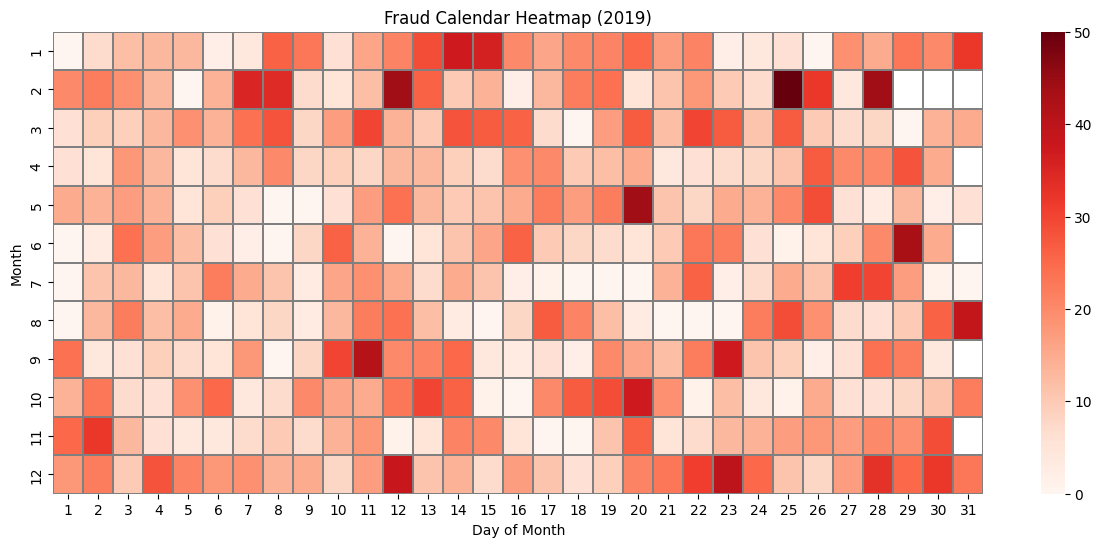

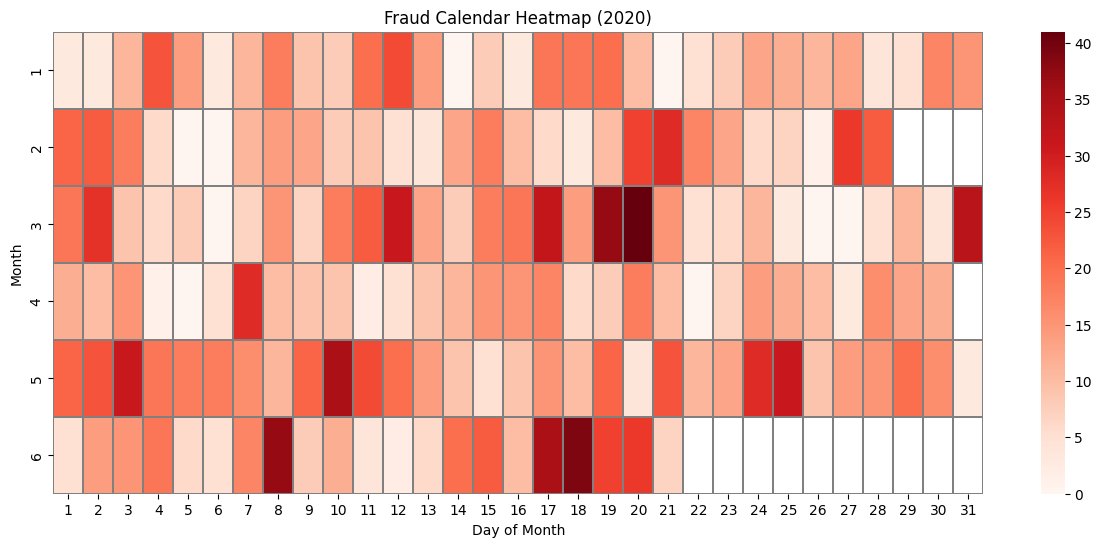

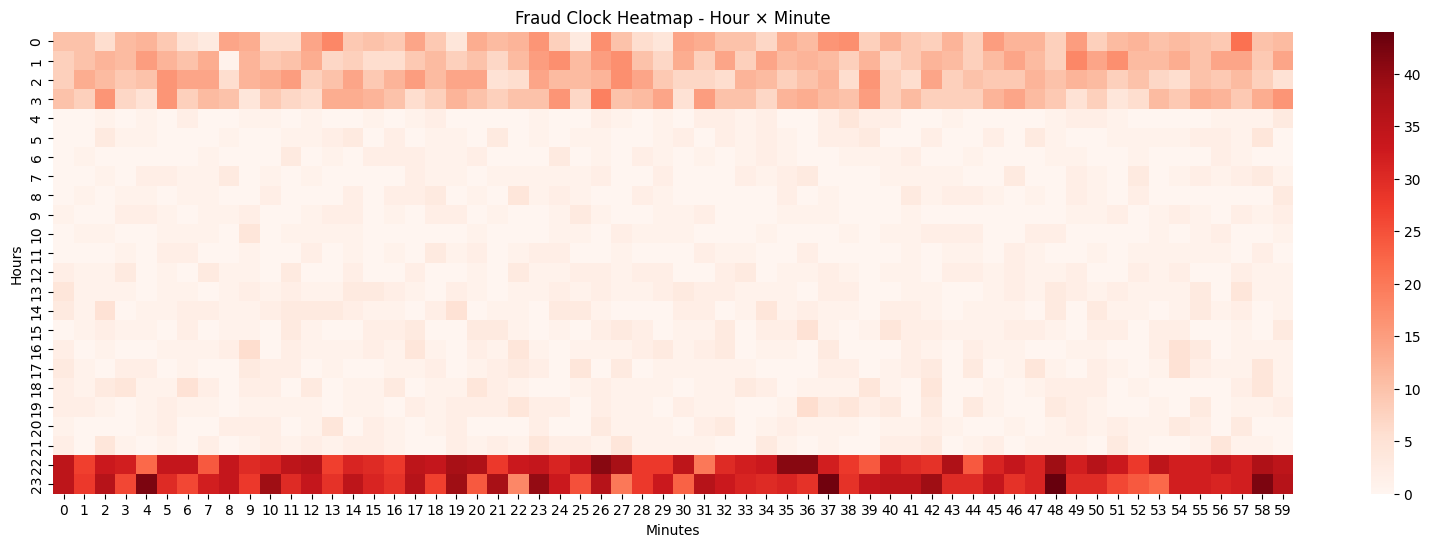

In [ ]:
df_viz["trans_date_trans_time"] = pd.to_datetime(df_viz["trans_date_trans_time"])
df_viz["year"] = df_viz["trans_date_trans_time"].dt.year
df_viz["month"] = df_viz["trans_date_trans_time"].dt.month
df_viz["day"] = df_viz["trans_date_trans_time"].dt.day
df_viz["hour"] = df_viz["trans_date_trans_time"].dt.hour
df_viz["minute"] = df_viz["trans_date_trans_time"].dt.minute
df_viz["second"] = df_viz["trans_date_trans_time"].dt.second

# =====================================================
# 1) CALENDAR HEATMAP (Year × Month × Day)
# =====================================================
fraud_calendar = df_viz.groupby(["year","month","day"])["is_fraud"].sum().reset_index()

for yr in sorted(fraud_calendar["year"].unique()):
    pivoted = fraud_calendar[fraud_calendar["year"]==yr].pivot(
        index="month", columns="day", values="is_fraud"
    )

    plt.figure(figsize=(15,6))
    sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
    plt.title(f"Fraud Calendar Heatmap ({yr})")
    plt.xlabel("Day of Month")
    plt.ylabel("Month")
    plt.show()

# =====================================================
# 2) CLOCK HEATMAP (Hour × Minute)
# =====================================================

fraud_clock_min = df_viz.groupby(["hour","minute"])["is_fraud"].sum().reset_index()

pivoted_clock_min = fraud_clock_min.pivot_table(
    index="hour", columns="minute", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_min, cmap="Reds", cbar=True)
plt.title("Fraud Clock Heatmap - Hour × Minute")
plt.xlabel("Minutes")
plt.ylabel("Hours")
plt.show()

#### DoB

In [ ]:
df_viz["dob"] = pd.to_datetime(df_viz["dob"])
df_viz["dob_year"] = df_viz["dob"].dt.year
df_viz["dob_month"] = df_viz["dob"].dt.month
df_viz["dob_day"] = df_viz["dob"].dt.day

In [ ]:
def feature_to_target(df, column):
    partition = df.groupby(column)["is_fraud"].sum().reset_index()

    # reshape into 1-row dataframe
    heatmap_data = partition.set_index(column).T

    plt.figure(figsize=(20, 2))
    sns.heatmap(
        heatmap_data,
        cmap="Reds",
        annot=False,  # disable is_fraud count labels
        cbar=True
    )
    plt.title(f"Fraud Count Heatmap by {column}")
    plt.yticks(rotation=0)
    plt.show()

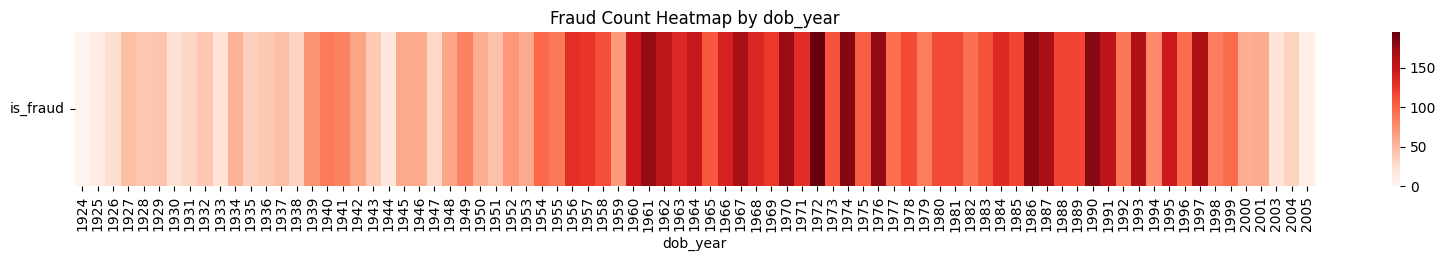

In [ ]:
feature_to_target(df_viz, "dob_year")

### Concatenate customer_name

In [ ]:
df_viz["customer_name"] = df_viz["first"].str.cat(df_viz["last"], sep=' ')

In [ ]:
df_viz["customer_name"].nunique()

973

In [ ]:
df_viz = df_viz.drop(["first", "last"], axis=1)

### Split merchant prefix

In [ ]:
df_viz["merchant"].str.startswith("fraud_").sum()

np.int64(1296675)

### Split street components

In [ ]:
splits = df_viz["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df_viz["str_number"]    = splits[0]
df_viz["str_name"]      = splits[1]
df_viz["str_type"]      = splits[2]
df_viz["building_type"] = splits[3]
df_viz["room_number"]   = splits[4]

df_viz = df_viz.drop('street', axis=1)

In [ ]:
df_viz.nunique()

,0
trans_date_trans_time,1274791
cc_num,983
merchant,693
category,14
amt,52928
gender,2
city,894
state,51
zip,970
lat,968


### Split zip prefix

In [ ]:
df_viz["zip"] = df_viz["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df_viz["zip_prefix"] = df_viz["zip"].str[:3]

In [ ]:
df_viz["zip_prefix"].nunique()

526

In [ ]:
df_viz["zip_prefix"].astype(int)
df_viz = df_viz.drop("zip", axis=1)

### Calculate distance (km) between merchants and customers

In [ ]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in kilometers
    return r * c

# Example usage with your DataFrame df
df_viz['distance_km'] = haversine_vectorized(
    df_viz['lat'], df_viz['long'], df_viz['merch_lat'], df_viz['merch_long']
)

df_viz = df_viz.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

### Calculating age

In [ ]:
df_viz["age"] = df_viz["year"] - df_viz["dob_year"]

### Drop datetime columns (trans_date_trans_time, dob), trans_num

In [ ]:
df_viz_samp_2 = df_viz.drop(["trans_date_trans_time", "dob", "trans_num"], axis=1)

### Correlation after transformation

In [ ]:
target_col = "is_fraud"   # replace with your target column name

# Move target column to the end
def reorder(df):
    cols = [c for c in df.columns if c != target_col] + [target_col]
    df = df[cols]
    return df

df_viz_samp_2 = reorder(df_viz_samp_2)

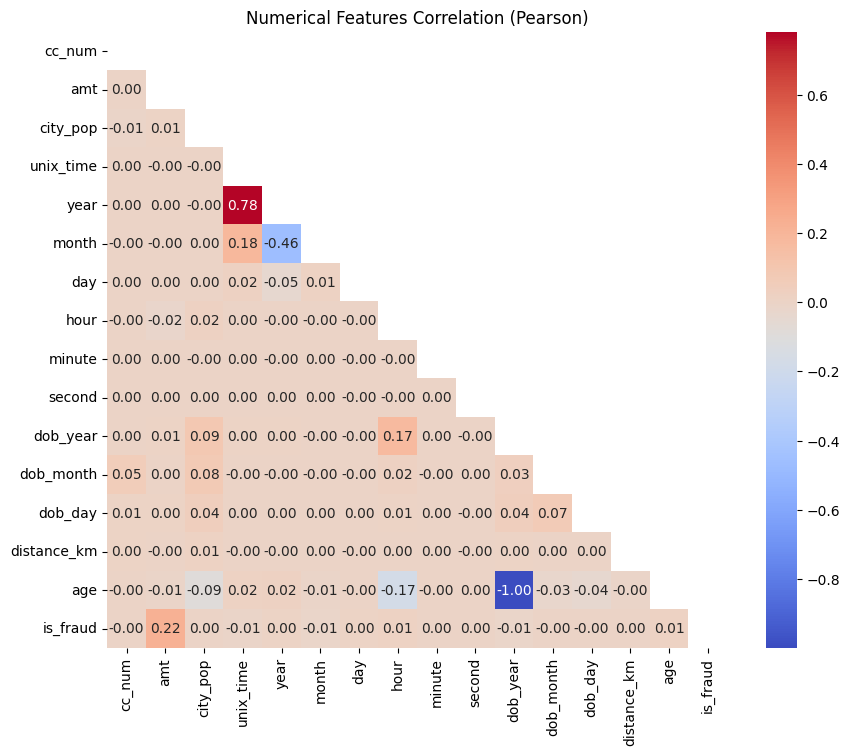

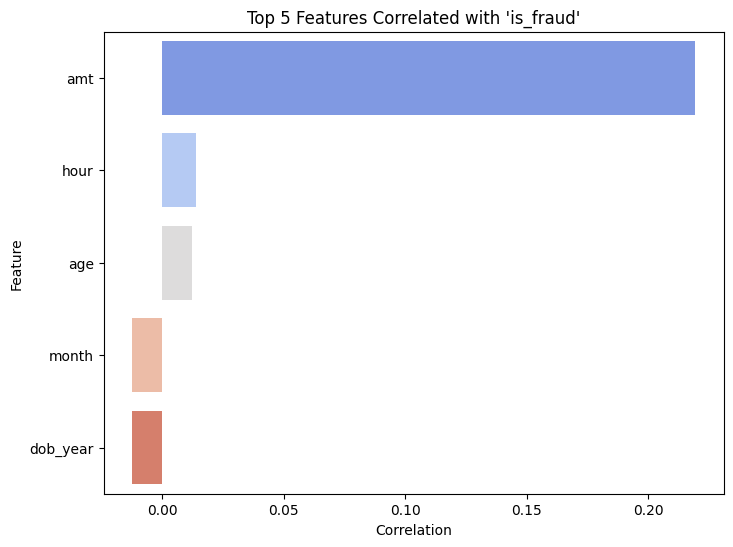

In [ ]:
num_corr(df_viz_samp_2)

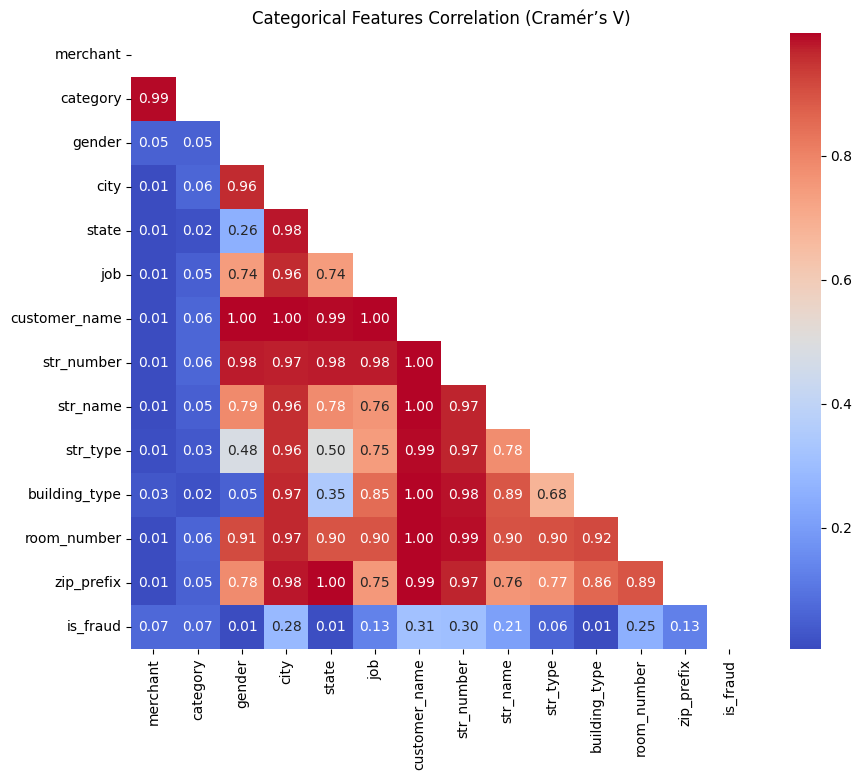

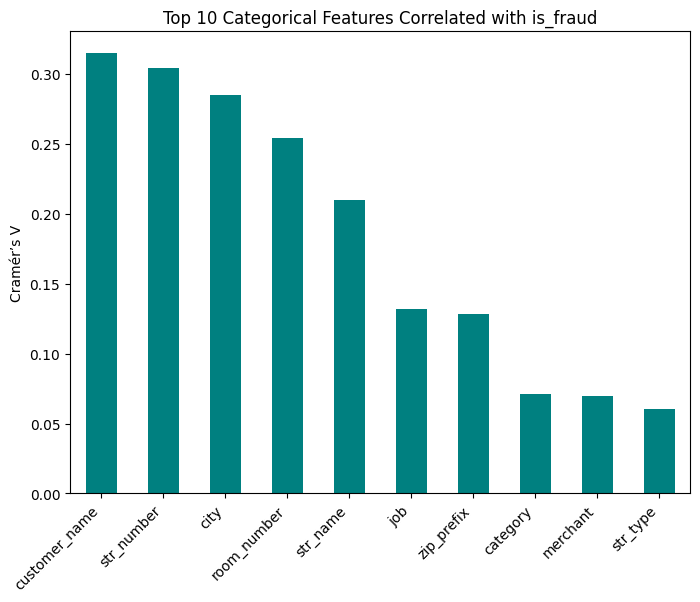

In [ ]:
cat_corr(df_viz_samp_2)

In [ ]:
df_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 32 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   gender                 1296675 non-null  object        
 6   city                   1296675 non-null  object        
 7   state                  1296675 non-null  object        
 8   city_pop               1296675 non-null  int64         
 9   job                    1296675 non-null  object        
 10  dob                    1296675 non-null  datetime64[ns]
 11  trans_num              1296675 non-null  object        
 12  unix_time              12966

## Relationship Analysis

### Fraud Rate by Category Spending

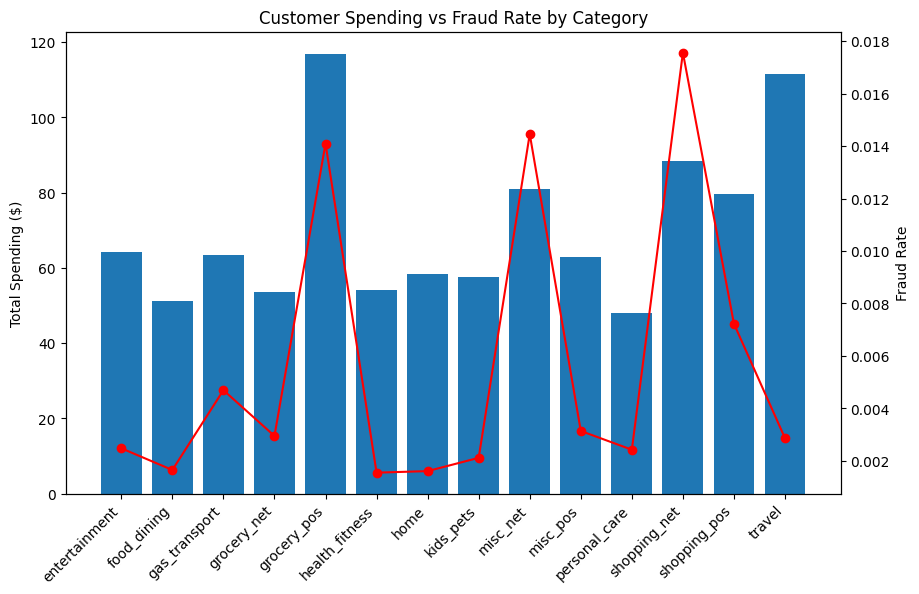

In [ ]:
fraud_by_cat_amt = (
    df_viz.groupby("category")
    .agg(
        total_spent=("amt", "mean"),
        fraud_cases=("is_fraud", "sum"),
        total_transactions=("is_fraud", "count")
    )
    .reset_index()
)

fraud_by_cat_amt["fraud_rate"] = (
    fraud_by_cat_amt["fraud_cases"] / fraud_by_cat_amt["total_transactions"]
)

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar for spending
ax1.bar(fraud_by_cat_amt["category"], fraud_by_cat_amt["total_spent"])
ax1.set_ylabel("Total Spending ($)")
ax1.set_xticklabels(fraud_by_cat_amt["category"], rotation=45, ha="right")

# Second axis for fraud rate
ax2 = ax1.twinx()
ax2.plot(fraud_by_cat_amt["category"], fraud_by_cat_amt["fraud_rate"], color="red", marker="o")
ax2.set_ylabel("Fraud Rate")

plt.title("Customer Spending vs Fraud Rate by Category")
plt.show()

### Fraud Cases by State

In [ ]:
df_state = df_viz.groupby("state")["is_fraud"].sum().reset_index()

fig = px.choropleth(df_state,
                    locations='state',
                    locationmode='USA-states',
                    color='is_fraud',
                    scope="usa",
                    color_continuous_scale="Reds",
                    labels={'is_fraud':'Fraud Rate'}
)
fig.update_layout(title_text="US Fraud Rate by State", geo_scope='usa')
fig.show()

### Total Amount of Transactions by State

In [ ]:
state_amt = df_viz.groupby("state").agg(
    total_amt=("amt", "sum"),
    total_transactions=("amt", "count")
).reset_index()

fig = px.choropleth(state_amt,
                    locations='state',
                    locationmode='USA-states',
                    color='total_amt',
                    scope="usa",
                    color_continuous_scale="Reds",
                    labels={'total_amt':'Total Amount'})

fig.update_layout(title_text="US Total Amount of Transactions by State", geo_scope='usa')
fig.show()

### Fraud Rate by Gender

In [ ]:
fraud_rate_gender = (
    df_viz.groupby("gender")["is_fraud"]
    .agg(["sum", "count"])
    .reset_index()
)

fraud_rate_gender["fraud_rate"] = (
    fraud_rate_gender["sum"] * 100 / fraud_rate_gender["count"]
)

print(fraud_rate_gender)

  gender   sum   count  fraud_rate
0      F  3735  709863    0.526158
1      M  3771  586812    0.642625


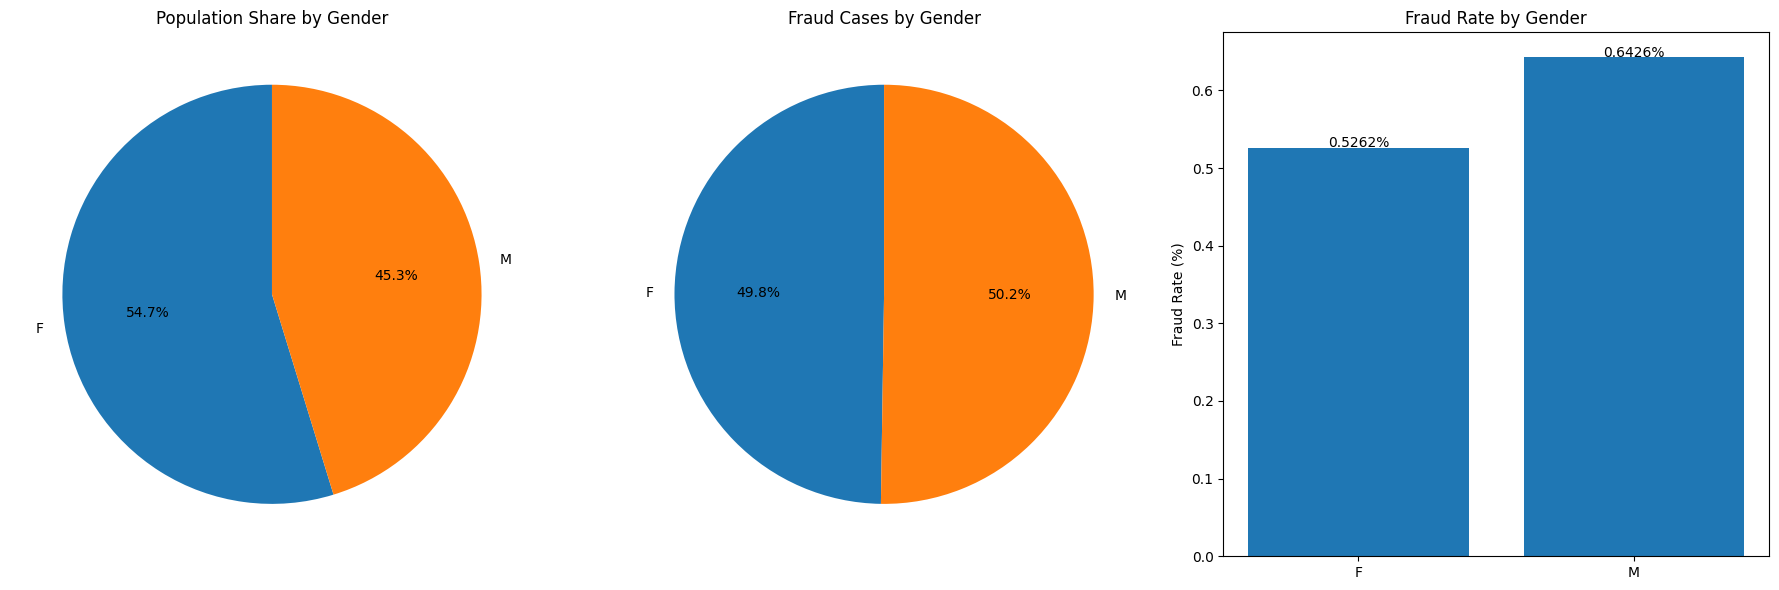

In [ ]:
# --- Data prep ---
# Population distribution
pop_share = fraud_rate_gender.set_index("gender")["count"]

# Fraud case distribution
fraud_cases = fraud_rate_gender.set_index("gender")["sum"]

# Fraud rate (% of each gender)
fraud_rate = fraud_rate_gender.set_index("gender")["fraud_rate"]

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# 1. Population share
axes[0].pie(pop_share, labels=pop_share.index, autopct="%.1f%%", startangle=90)
axes[0].set_title("Population Share by Gender")

# 2. Fraud case share
axes[1].pie(fraud_cases, labels=fraud_cases.index, autopct="%.1f%%", startangle=90)
axes[1].set_title("Fraud Cases by Gender")

# 3. Fraud rate (better as bar than pie because values are very small)
axes[2].bar(fraud_rate.index, fraud_rate.values)
axes[2].set_title("Fraud Rate by Gender")
axes[2].set_ylabel("Fraud Rate (%)")
for i, v in enumerate(fraud_rate.values):
    axes[2].text(i, v + 0.001, f"{v:.4f}%", ha="center")  # show 4 decimals since ~0.05%

plt.tight_layout()
plt.show()

### Amount vs fraud

In [ ]:
df.groupby("is_fraud")["amt"].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.0,67.667110,154.007971,1.00,9.6100,47.280,82.540,28948.90
1,7506.0,531.320092,390.560070,1.06,245.6625,396.505,900.875,1376.04


In [ ]:
# --- Compute median amount ---
median_amt = df_viz["amt"].median()

# --- Count high-amount frauds per customer (without modifying df) ---
high_amt_fraud_counts = df_viz.loc[(df_viz["amt"] > median_amt) & (df_viz["is_fraud"] == 1)]
customer_counts = high_amt_fraud_counts.groupby("customer_name").size().reset_index(name="num_high_amt_fraud")

# Average number of high-amount frauds per customer
avg_high_amt_fraud_per_customer = customer_counts["num_high_amt_fraud"].mean()

# Total number of high-amount transactions
total_high_amt = df_viz["amt"].loc[df_viz["amt"] > median_amt].mean()

# Compute ratio
ratio = avg_high_amt_fraud_per_customer*100 / total_high_amt

print(f"Probability that a transaction with higher than median amount is fradulent: {ratio:.2f}%")

Probability that a transaction with higher than median amount is fradulent: 6.37%


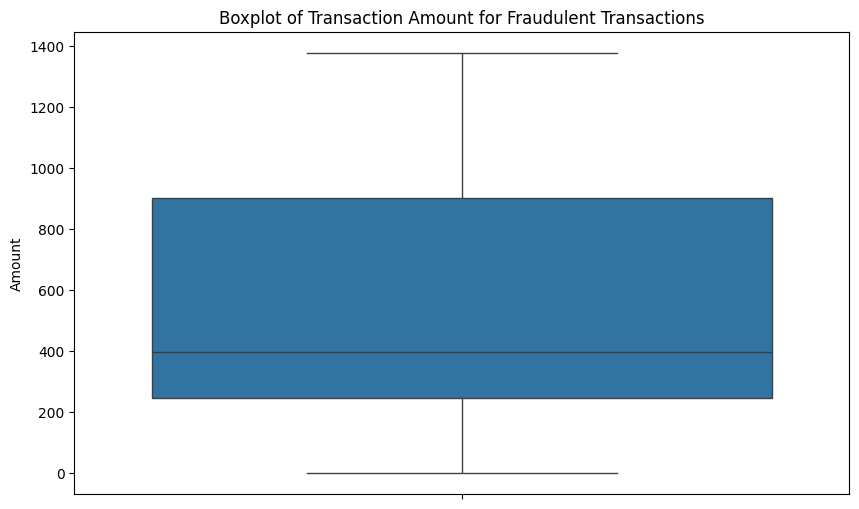

In [ ]:
# Filter the DataFrame to include only fraudulent transactions
fraud_df = df_viz[df_viz['is_fraud'] == 1]

plt.figure(figsize=(10, 6))
sns.boxplot(y=fraud_df['amt'])
plt.title('Boxplot of Transaction Amount for Fraudulent Transactions')
plt.ylabel('Amount')
plt.show()

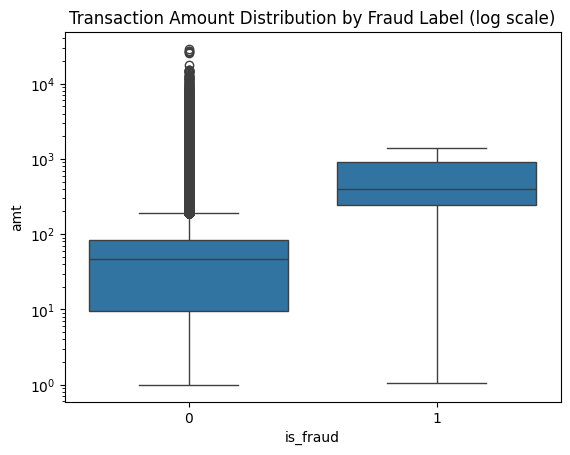

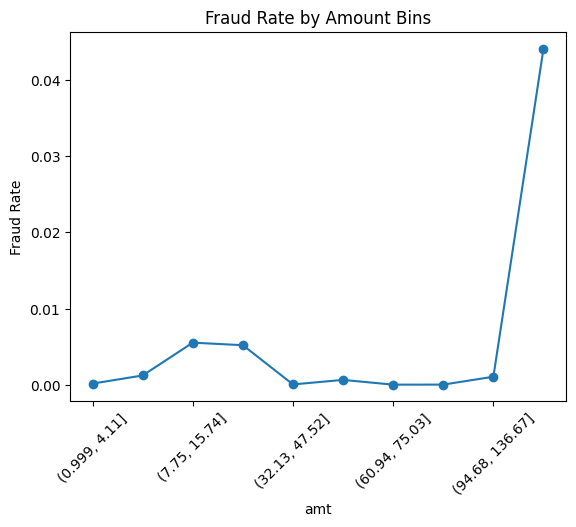

In [ ]:
sns.boxplot(x="is_fraud", y="amt", data=df_viz)
plt.yscale("log")
plt.title("Transaction Amount Distribution by Fraud Label (log scale)")
plt.show()

# --- Fraud rate by amount bins (quantiles) ---
amount_bins = pd.qcut(df_viz["amt"], q=10)  # 10 quantile bins
fraud_rate = df_viz.groupby(amount_bins)["is_fraud"].mean()

fraud_rate.plot(kind="line", marker="o", title="Fraud Rate by Amount Bins")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()



### Analyze fraud rate by time difference


In [ ]:
df_viz_date = df_viz.sort_values(by=["cc_num", "trans_date_trans_time"])
df_viz_date["time_delta"] = df_viz_date.groupby("cc_num")["trans_date_trans_time"].diff().dt.total_seconds() / 3600

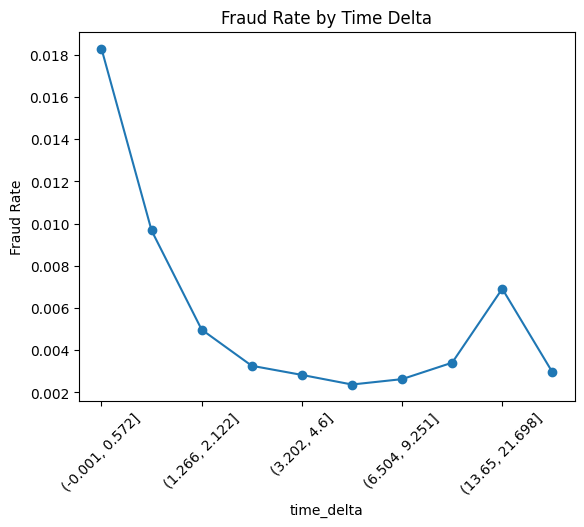

In [ ]:
# Create quantile bins on the fly
time_bins = pd.qcut(df_viz_date["time_delta"].dropna(), q=10)

# Group by bins and compute fraud rate
fraud_rate_by_bin = df_viz_date.groupby(time_bins)["is_fraud"].mean()

# Plot
fraud_rate_by_bin.plot(kind="line", marker="o", title="Fraud Rate by Time Delta")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()

### Fraud by Generations


In [ ]:
def categorize_generation(year):
    if 1924 <= year <= 1945:
        return "The Silent: 1924-1945"
    elif 1946 <= year <= 1964:
        return "Baby Boomer: 1946-1964"
    elif 1965 <= year <= 1979:
        return "Gen X: 1965-1979"
    elif 1980 <= year <= 1994:
        return "Millennials: 1980-1994"
    else:
        return "Gen Z: 1995+"

df_viz['generations'] = df_viz['dob_year'].apply(categorize_generation)

In [ ]:
fraud_customers = (
    df_viz[df_viz["is_fraud"] == 1]
    .groupby("generations")["customer_name"]
    .nunique()
    .reset_index(name="n_customers_with_fraud")
)

total_customers = (
    df_viz.groupby("generations")["customer_name"]
    .nunique()
    .reset_index(name="n_customers")
)

fraud_by_generation = fraud_customers.merge(total_customers, on="generations")

count_fraud_generation = fraud_by_generation.copy()

fraud_by_generation["fraud_ratio"] = (
    fraud_by_generation["n_customers_with_fraud"]
    / fraud_by_generation["n_customers"]
)

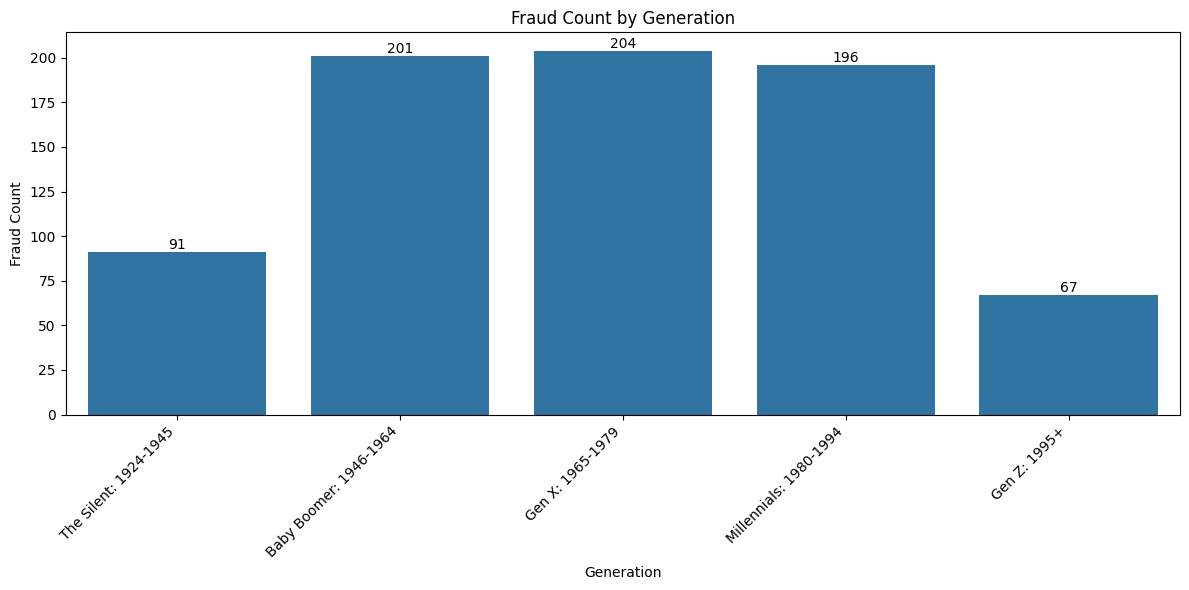

In [ ]:
# Define the desired order of generations
generation_order = [
    "The Silent: 1924-1945",
    "Baby Boomer: 1946-1964",
    "Gen X: 1965-1979",
    "Millennials: 1980-1994",
    "Gen Z: 1995+"
]

# # Convert 'generation' to a categorical type with the specified order
fraud_by_generation['generations'] = pd.Categorical(
    fraud_by_generation['generations'], categories=generation_order, ordered=True
)

# Sort by the categorical 'generation' column
fraud_by_generation = fraud_by_generation.sort_values('generations')

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=fraud_by_generation,
    x='generations',
    y='n_customers_with_fraud' # Change y-axis to fraud count
     )

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.0f}",  # format as integer count
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=10, color="black"
    )

plt.title("Fraud Count by Generation")
plt.xlabel("Generation")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 3: Preprocessing

## 3.1. Train set preprocessing

### Time

In [ ]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["year"] = df["trans_date_trans_time"].dt.year
df["month"] = df["trans_date_trans_time"].dt.month
df["day"] = df["trans_date_trans_time"].dt.day
df["hour"] = df["trans_date_trans_time"].dt.hour
df["minute"] = df["trans_date_trans_time"].dt.minute
df["second"] = df["trans_date_trans_time"].dt.second

#### Day vs Night


In [ ]:
def categorize_time_of_day(hour):
    if 18 <= hour or hour < 6:
        return 'Night'
    else:
        return 'Day'

df['time_of_day'] = df['hour'].apply(categorize_time_of_day)

#### Time Delta

In [ ]:
df = df.sort_values(by=["cc_num", "trans_date_trans_time"])

# Calculate time difference between 2 transactions of the same cc_num
df["prev_txn_date"] = df.groupby("cc_num")["trans_date_trans_time"].shift(1)
df["time_delta"] = (df["trans_date_trans_time"] - df["prev_txn_date"]).dt.total_seconds() / 3600  # by hours

#### Split DoB

In [ ]:
df["dob"] = pd.to_datetime(df["dob"])
df["dob_year"] = df["dob"].dt.year
df["dob_month"] = df["dob"].dt.month
df["dob_day"] = df["dob"].dt.day

#### Calculating age

In [ ]:
df["age"] = df["year"] - df["dob_year"]

#### Rewrite unix_time

In [ ]:
# As the original unix_time is not appropriate, decoding unix_time gives another date different from the trans_date, I will drop it
df = df.drop("unix_time", axis=1)

In [ ]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

# Create a new column with unix_time (seconds since epoch)
df["unix_time"] = df["trans_date_trans_time"].astype(int) // 10**9

### Split street components

In [ ]:
splits = df["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df["str_number"]    = splits[0]
df["str_name"]      = splits[1]
df["str_type"]      = splits[2]
df["building_type"] = splits[3]
df["room_number"]   = splits[4]

df = df.drop('street', axis=1)

In [ ]:
df["building_type"] = df["building_type"].replace({None: "House"})

### Split zip prefix

In [ ]:
df["zip"] = df["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df["zip_prefix"] = df["zip"].str[:3]

In [ ]:
df["zip_prefix"].astype(int)
df = df.drop("zip", axis=1)

### Calculate distance (km) between merchants and customers

In [ ]:
df['distance_km'] = haversine_vectorized(
    df['lat'], df['long'], df['merch_lat'], df['merch_long']
)

df = df.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

### Overwrite job

In [ ]:
# Overwrite 'job' with only the first element before the comma
df["job"] = df["job"].str.split(",").str[0].str.strip()

### Generations

In [ ]:
df['generations'] = df['dob_year'].apply(categorize_generation)

### Prepare train set

#### Prepare train set for Light GBM

In [ ]:
df_lgbm = df.copy()

In [ ]:
df_lgbm["customer_name"] = df_lgbm["first"].str.cat(df_lgbm["last"], sep=' ')

In [ ]:
df_lgbm["n_cc"] = df_lgbm.groupby("customer_name")["cc_num"].transform("nunique")

In [ ]:
# Select only numeric features
num_cols = df_lgbm.select_dtypes(include=['int64', 'float64']).columns

# Compute skewness for each numeric column
skewness = df_lgbm[num_cols].apply(lambda x: skew(x.dropna()))
skewness = skewness.sort_values(ascending=False)

print(skewness)

amt            42.277825
is_fraud       13.029107
n_cc            7.858677
city_pop        5.593847
time_delta      4.278013
cc_num          2.851876
unix_time       0.010313
distance_km    -0.236207
dtype: float64


In [ ]:
df_lgbm["amt"] = np.log1p(df_lgbm["amt"])   # log(amt+1)

In [ ]:
df_lgbm["fraud_doubt_1"] = df_lgbm["hour"].apply(
    lambda h: 1 if (h >= 22 or h <= 3) else 0
)

In [ ]:
class FraudDoubt2:
    def __init__(self):
        self.avg_time_per_category = None

    def fit(self, df_lgbm):
        self.avg_time_per_category = (
            df_lgbm.groupby("category")["time_delta"].mean()
        ).to_dict()
        return self

    def transform(self, df_lgbm):
        df_lgbm["avg_time_cat"] = df_lgbm["category"].map(self.avg_time_per_category)
        df_lgbm["fraud_doubt_2"] = (df_lgbm["time_delta"] < df_lgbm["avg_time_cat"]).astype(int)
        return df_lgbm

In [ ]:
flag2 = FraudDoubt2().fit(df_lgbm)
df_lgbm = flag2.transform(df_lgbm)

In [ ]:
class FraudDoubt3:
    def __init__(self):
        self.mode_strname_per_category = None

    def fit(self, df_lgbm):
        self.mode_strname_per_category = (
            df_lgbm.groupby("category")["str_name"].agg(lambda x: x.mode()[0])
        ).to_dict()
        return self

    def transform(self, df_lgbm):
        df_lgbm["mode_strname_cat"] = df_lgbm["category"].map(self.mode_strname_per_category)
        df_lgbm["fraud_doubt_3"] = (df_lgbm["str_name"] != df_lgbm["mode_strname_cat"]).astype(int)
        return df_lgbm

In [ ]:
flag3 = FraudDoubt3().fit(df_lgbm)
df_lgbm = flag3.transform(df_lgbm)

In [ ]:
east_states = {
    "ME","NH","VT","MA","RI","CT","NY","NJ","PA","DE","MD","VA","NC","SC",
    "GA","FL","WV","OH","IN","MI","KY","TN","AL","MS"
}

west_states = {
    "WA","OR","CA","NV","ID","MT","WY","UT","CO","AZ","NM","AK","HI"
}

# everything not in east/west can be considered "Central" if you want
df_lgbm["state"] = df_lgbm["state"].apply(
    lambda x: "East" if x in east_states else ("West" if x in west_states else "Central")
)

In [ ]:
df_lgbm = df_lgbm.drop(["trans_date_trans_time", "merchant", "first", "last", "city", "dob", "trans_num", "customer_name", "prev_txn_date"], axis=1)

In [ ]:
df_lgbm = df_lgbm.drop(["mode_strname_cat", "str_name", "str_type", "job"], axis=1)

In [ ]:
df_lgbm["room_number"] = df_lgbm["room_number"].fillna(0)
df_lgbm["room_number"] = df_lgbm["room_number"].astype(int)
df_lgbm["str_number"] = df_lgbm["str_number"].astype(int)

In [ ]:
df_lgbm["time_delta"] = df_lgbm["time_delta"].fillna(0)

In [ ]:
df_lgbm = df_lgbm.dropna()

In [ ]:
# Function to relocate target column to the end of the dataset
def reorder(df):
    target_col = "is_fraud"
    cols = [c for c in df.columns if c != target_col] + [target_col]
    df = df[cols]
    return df

df_lgbm = reorder(df_lgbm)

In [ ]:
# Define categorical columns (must be column names or indices)
categorical_cols = df_lgbm.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    df_lgbm[col] = df_lgbm[col].astype("category")

X = df_lgbm.drop(columns=["is_fraud"])
y = df_lgbm["is_fraud"]

# Split dataset
X_train_lgbm, X_val_lgbm, y_train_lgbm, y_val_lgbm = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Prepare train set for LogisiticReg, RF and XGBoost

In [ ]:
df_train = df.drop(columns=["first", "last","str_number","room_number","cc_num","trans_date_trans_time", "prev_txn_date","unix_time", "dob","trans_num","city","building_type"],axis=1)

In [ ]:
df_train.select_dtypes(include=['object', 'category']).nunique()

,0
merchant,693
category,14
gender,2
state,51
job,415
time_of_day,2
str_name,552
str_type,193
zip_prefix,526
generations,5


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 1017 to 1296427
Data columns (total 25 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   merchant     1296675 non-null  object 
 1   category     1296675 non-null  object 
 2   amt          1296675 non-null  float64
 3   gender       1296675 non-null  object 
 4   state        1296675 non-null  object 
 5   city_pop     1296675 non-null  int64  
 6   job          1296675 non-null  object 
 7   is_fraud     1296675 non-null  int64  
 8   year         1296675 non-null  int32  
 9   month        1296675 non-null  int32  
 10  day          1296675 non-null  int32  
 11  hour         1296675 non-null  int32  
 12  minute       1296675 non-null  int32  
 13  second       1296675 non-null  int32  
 14  time_of_day  1296675 non-null  object 
 15  time_delta   1295692 non-null  float64
 16  dob_year     1296675 non-null  int32  
 17  dob_month    1296675 non-null  int32  
 18  dob_

In [ ]:
df_train=df_train.dropna()

In [ ]:
df_train

,merchant,category,amt,gender,state,city_pop,job,is_fraud,year,month,day,hour,minute,second,time_of_day,time_delta,dob_year,dob_month,dob_day,age,str_name,str_type,zip_prefix,distance_km,generations
2724,fraud_Berge LLC,gas_transport,52.94,F,WY,1645,Information systems manager,0,2019,1,2,8,44,57,Day,19.961667,1986,2,17,33,Anita,Drive,825,110.308921,Millennials: 1980-1994
2726,fraud_Luettgen PLC,gas_transport,82.08,F,WY,1645,Information systems manager,0,2019,1,2,8,47,36,Day,0.044167,1986,2,17,33,Anita,Drive,825,21.787261,Millennials: 1980-1994
2882,fraud_Daugherty LLC,kids_pets,34.79,F,WY,1645,Information systems manager,0,2019,1,2,12,38,14,Day,3.843889,1986,2,17,33,Anita,Drive,825,87.204215,Millennials: 1980-1994
2907,fraud_Beier and Sons,home,27.18,F,WY,1645,Information systems manager,0,2019,1,2,13,10,46,Day,0.542222,1986,2,17,33,Anita,Drive,825,74.212965,Millennials: 1980-1994
4135,fraud_Stamm-Witting,shopping_net,6.87,F,WY,1645,Information systems manager,0,2019,1,3,13,56,35,Day,24.763611,1986,2,17,33,Anita,Drive,825,69.984956,Millennials: 1980-1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294934,"fraud_Berge, Kautzer and Harris",personal_care,60.47,M,IL,532,Audiological scientist,0,2020,6,20,21,4,59,Night,8.538889,1956,1,9,64,Patrick,Light,613,78.492562,Baby Boomer: 1946-1964
1295369,fraud_Bernhard Inc,gas_transport,74.29,M,IL,532,Audiological scientist,0,2020,6,21,0,41,1,Night,3.600556,1956,1,9,64,Patrick,Light,613,55.400768,Baby Boomer: 1946-1964
1295587,"fraud_Reichert, Rowe and Mraz",shopping_net,246.56,M,IL,532,Audiological scientist,0,2020,6,21,2,47,59,Night,2.116111,1956,1,9,64,Patrick,Light,613,115.674400,Baby Boomer: 1946-1964
1296206,fraud_Jewess LLC,shopping_pos,2.62,M,IL,532,Audiological scientist,0,2020,6,21,8,4,28,Day,5.274722,1956,1,9,64,Patrick,Light,613,60.513397,Baby Boomer: 1946-1964


### Encode train set for LogisticReg, RF and XGBoost

In [ ]:
# Copy dữ liệu gốc
train_encoded = df_train.copy()

# --------------------------
# 1. Frequency Encoding
# --------------------------
freq_cols = ["merchant", "state", "str_name", "str_type","job","zip_prefix"]
for col in freq_cols:
    freq_map = train_encoded[col].value_counts(normalize=True)  # tỷ lệ xuất hiện
    train_encoded[col + "_freq"] = train_encoded[col].map(freq_map)

# --------------------------
# 2. One-Hot Encoding
# --------------------------
onehot_cols = ["category", "gender", "time_of_day"]
train_encoded = pd.get_dummies(train_encoded, columns=onehot_cols, drop_first=True)

# # --------------------------
# # 3. Target Encoding
# # --------------------------
# target_cols = ["job", "zip_prefix"]
# te = TargetEncoder(cols=target_cols)
# train2_encoded[target_cols] = te.fit_transform(train2_encoded[target_cols], train2_encoded["is_fraud"])

# --------------------------
# 4. Label Encoding
# --------------------------
label_col = "generations"
le = LabelEncoder()
train_encoded[label_col] = le.fit_transform(train_encoded[label_col])

# --------------------------
# Done
# --------------------------
train_encoded = train_encoded.drop(columns=freq_cols  + [label_col])
df_train_encoded = train_encoded.copy()


In [ ]:
target_col = "is_fraud"   # replace with your target column name

#Move target column to the end
cols = [c for c in df_train_encoded if c != target_col] + [target_col]
df_train_encoded = df_train_encoded[cols]

##  3.2. Test set preprocessing

In [ ]:
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"])
df_test["year"] = df_test["trans_date_trans_time"].dt.year
df_test["month"] = df_test["trans_date_trans_time"].dt.month
df_test["day"] = df_test["trans_date_trans_time"].dt.day
df_test["hour"] = df_test["trans_date_trans_time"].dt.hour
df_test["minute"] = df_test["trans_date_trans_time"].dt.minute
df_test["second"] = df_test["trans_date_trans_time"].dt.second

In [ ]:
df_test["dob"] = pd.to_datetime(df_test["dob"])
df_test["dob_year"] = df_test["dob"].dt.year
df_test["dob_month"] = df_test["dob"].dt.month
df_test["dob_day"] = df_test["dob"].dt.day

In [ ]:
df_test["age"] = df_test["year"] - df_test["dob_year"]

In [ ]:
df_test["zip"] = df_test["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df_test["zip_prefix"] = df_test["zip"].str[:3]
df_test = df_test.drop("zip", axis=1)

In [ ]:
# Example usage with your DataFrame df
df_test['distance_km'] = haversine_vectorized(
    df_test['lat'], df_test['long'], df_test['merch_lat'], df_test['merch_long']
)

df_test = df_test.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

In [ ]:
df_test["job"] = df_test["job"].str.split(",").str[0].str.strip()

In [ ]:
splits_test = df_test["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df_test["str_number"]    = splits[0]
df_test["str_name"]      = splits[1]
df_test["str_type"]      = splits[2]
df_test["building_type"] = splits[3]
df_test["room_number"]   = splits[4]

df_test = df_test.drop('street', axis=1)

In [ ]:
df_test["building_type"] = df_test["building_type"].replace({None: "House"})

In [ ]:
df_test['time_of_day'] = df_test['hour'].apply(categorize_time_of_day)

In [ ]:
df_test = df_test.sort_values(by=["cc_num", "trans_date_trans_time"])
# Tính khoảng thời gian (delta) giữa 2 giao dịch liên tiếp của cùng 1 thẻ
df_test["prev_txn_date"] = df_test.groupby("cc_num")["trans_date_trans_time"].shift(1)
df_test["time_delta"] = (df_test["trans_date_trans_time"] - df_test["prev_txn_date"]).dt.total_seconds() / 3600  # tính theo giờ

In [ ]:
#generation
df_test['generations'] = df_test['dob_year'].apply(categorize_generation)

### Prepare test set

#### Prepare test set for Light GBM

In [ ]:
df_test_lgbm = df_test.copy()

In [ ]:
df_test_lgbm["customer_name"] = df_test_lgbm["first"].str.cat(df_test_lgbm["last"], sep=' ')

In [ ]:
df_test_lgbm["n_cc"] = df_test_lgbm.groupby("customer_name")["cc_num"].transform("nunique")

In [ ]:
# Select only numeric features
num_cols = df_test_lgbm.select_dtypes(include=['int64', 'float64']).columns

# Compute skewness for each numeric column
skewness = df_test_lgbm[num_cols].apply(lambda x: skew(x.dropna()))
skewness = skewness.sort_values(ascending=False)

print(skewness)

amt            37.133977
is_fraud       16.002510
n_cc            8.206144
city_pop        5.583400
time_delta      4.187849
cc_num          2.849196
unix_time      -0.077405
distance_km    -0.234440
dtype: float64


In [ ]:
df_test_lgbm["amt"] = np.log1p(df_test_lgbm["amt"])   # log(amt+1)

In [ ]:
# Create binary feature
df_test_lgbm["fraud_doubt_1"] = df_test_lgbm["hour"].apply(
    lambda h: 1 if (h >= 22 or h <= 3) else 0
)

In [ ]:
df_test_lgbm = flag2.transform(df_test_lgbm)

In [ ]:
df_test_lgbm = flag3.transform(df_test_lgbm)

In [ ]:
east_states = {
    "ME","NH","VT","MA","RI","CT","NY","NJ","PA","DE","MD","VA","NC","SC",
    "GA","FL","WV","OH","IN","MI","KY","TN","AL","MS"
}

west_states = {
    "WA","OR","CA","NV","ID","MT","WY","UT","CO","AZ","NM","AK","HI"
}

# everything not in east/west can be considered "Central" if you want
df_test_lgbm["state"] = df_test_lgbm["state"].apply(
    lambda x: "East" if x in east_states else ("West" if x in west_states else "Central")
)

In [ ]:
df_test_lgbm = df_test_lgbm.drop(["trans_date_trans_time", "merchant", "first", "last", "city", "dob", "trans_num", "customer_name", "prev_txn_date"], axis=1)

In [ ]:
df_test_lgbm = df_test_lgbm.drop(["mode_strname_cat", "str_name", "str_type", "job"], axis=1)

In [ ]:
df_test_lgbm["room_number"] = df_test_lgbm["room_number"].fillna(0)
df_test_lgbm["str_number"] = df_test_lgbm["str_number"].astype(int)
df_test_lgbm["room_number"]  = df_test_lgbm["room_number"] .astype(int)

In [ ]:
df_test_lgbm["time_delta"] = df_test_lgbm["time_delta"].fillna(0)

In [ ]:
df_test_lgbm = df_test_lgbm.dropna()

In [ ]:
df_test_lgbm = reorder(df_test_lgbm)

In [ ]:
X_test_lgbm = df_test_lgbm.drop(columns=["is_fraud"])
y_test_lgbm = df_test_lgbm["is_fraud"]

In [ ]:
categorical_cols = X_test_lgbm.select_dtypes(include=["object", "category"]).columns.tolist()

# Convert to category dtype
for col in categorical_cols:
    X_test_lgbm[col] = X_test_lgbm[col].astype("category")

#### Prepare test set for LogisticReg, RF and XGBoost

In [ ]:
df_test = df_test.drop(columns=["first","last","trans_num","str_number","room_number","city","cc_num","trans_date_trans_time", "prev_txn_date","unix_time", "dob","building_type"],axis=1)

In [ ]:
df_test = df_test.dropna()

In [ ]:
df_test

,merchant,category,amt,gender,state,city_pop,job,is_fraud,year,month,day,hour,minute,second,dob_year,dob_month,dob_day,age,zip_prefix,distance_km,str_name,str_type,time_of_day,time_delta,generations
741,fraud_Halvorson Group,misc_pos,78.52,F,WY,1645,Information systems manager,0,2020,6,21,16,25,36,1986,2,17,34,825,91.942935,Green,Forks,Day,3.331667,Millennials: 1980-1994
3047,fraud_Conroy-Cruickshank,gas_transport,65.25,F,WY,1645,Information systems manager,0,2020,6,22,7,58,33,1986,2,17,34,825,121.857420,Peterson,Land,Day,15.549167,Millennials: 1980-1994
4351,fraud_Larkin Ltd,kids_pets,87.74,F,WY,1645,Information systems manager,0,2020,6,22,15,32,31,1986,2,17,34,825,65.414164,Yu,Locks,Day,7.566111,Millennials: 1980-1994
7695,fraud_Leffler-Goldner,personal_care,148.02,F,WY,1645,Information systems manager,0,2020,6,23,12,28,54,1986,2,17,34,825,38.311273,William,Dale,Day,20.939722,Millennials: 1980-1994
8059,"fraud_Kihn, Abernathy and Douglas",shopping_net,2.83,F,WY,1645,Information systems manager,0,2020,6,23,14,24,48,1986,2,17,34,825,61.986305,Mckenzie,Stream,Day,1.931667,Millennials: 1980-1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552584,fraud_Parisian and Sons,gas_transport,66.11,M,IL,532,Audiological scientist,0,2020,12,31,2,10,10,1956,1,9,64,613,44.885043,Chad,Lake,Night,2.243611,Baby Boomer: 1946-1964
552892,fraud_Bogisich-Homenick,misc_net,4.58,M,IL,532,Audiological scientist,0,2020,12,31,5,13,35,1956,1,9,64,613,81.485915,Luna,Brook,Night,3.056944,Baby Boomer: 1946-1964
553559,fraud_Erdman-Kertzmann,gas_transport,95.96,M,IL,532,Audiological scientist,0,2020,12,31,11,15,44,1956,1,9,64,613,36.046110,David,Locks,Day,6.035833,Baby Boomer: 1946-1964
553560,fraud_Stracke-Lemke,grocery_pos,149.48,M,IL,532,Audiological scientist,0,2020,12,31,11,17,25,1956,1,9,64,613,81.769332,Morgan,River,Day,0.028056,Baby Boomer: 1946-1964


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1295692 entries, 2724 to 1296427
Data columns (total 25 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   merchant     1295692 non-null  object 
 1   category     1295692 non-null  object 
 2   amt          1295692 non-null  float64
 3   gender       1295692 non-null  object 
 4   state        1295692 non-null  object 
 5   city_pop     1295692 non-null  int64  
 6   job          1295692 non-null  object 
 7   is_fraud     1295692 non-null  int64  
 8   year         1295692 non-null  int32  
 9   month        1295692 non-null  int32  
 10  day          1295692 non-null  int32  
 11  hour         1295692 non-null  int32  
 12  minute       1295692 non-null  int32  
 13  second       1295692 non-null  int32  
 14  time_of_day  1295692 non-null  object 
 15  time_delta   1295692 non-null  float64
 16  dob_year     1295692 non-null  int32  
 17  dob_month    1295692 non-null  int32  
 18  dob_

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554795 entries, 741 to 553883
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   merchant     554795 non-null  object 
 1   category     554795 non-null  object 
 2   amt          554795 non-null  float64
 3   gender       554795 non-null  object 
 4   state        554795 non-null  object 
 5   city_pop     554795 non-null  int64  
 6   job          554795 non-null  object 
 7   is_fraud     554795 non-null  int64  
 8   year         554795 non-null  int32  
 9   month        554795 non-null  int32  
 10  day          554795 non-null  int32  
 11  hour         554795 non-null  int32  
 12  minute       554795 non-null  int32  
 13  second       554795 non-null  int32  
 14  dob_year     554795 non-null  int32  
 15  dob_month    554795 non-null  int32  
 16  dob_day      554795 non-null  int32  
 17  age          554795 non-null  int32  
 18  zip_prefix   554795 non-nul

In [ ]:
# match train columns
df_test = df_test[df_train.columns]

### Encode test set for LogisticReg, RF and XGBoost

In [ ]:
test_encoded = df_test.copy()

# --------------------------
# 1. Frequency Encoding (dùng freq_map từ train)
# --------------------------
for col in freq_cols:
    freq_map = df_train[col].value_counts(normalize=True)  # lấy map từ train
    test_encoded[col + "_freq"] = test_encoded[col].map(freq_map).fillna(0)

# --------------------------
# 2. One-Hot Encoding (align với train)
# --------------------------
test_encoded = pd.get_dummies(test_encoded, columns=onehot_cols, drop_first=True)

# Thêm các cột còn thiếu để align với train
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

# # --------------------------
# # 3. Target Encoding (dùng encoder fit trên train)
# # --------------------------
# test_encoded[target_cols] = te.transform(test_encoded[target_cols])

# --------------------------
# 4. Label Encoding (dùng encoder fit trên train)
# --------------------------
test_encoded[label_col] = test_encoded[label_col].map(
    lambda x: le.transform([x])[0] if x in le.classes_ else -1
)

# --------------------------
# 5. Drop categorical gốc (giống train)
# --------------------------
test_encoded = test_encoded.drop(columns=freq_cols + [label_col])

# --------------------------
# 6. Reorder columns để giống train_encoded
# --------------------------
test_encoded = test_encoded[df_train_encoded.columns]

df_test_encoded = test_encoded.copy()

print("Test set encoded shape:", df_test_encoded.shape)
display(df_test_encoded.head())

Test set encoded shape: (554795, 36)


,amt,city_pop,year,month,day,hour,minute,second,time_delta,dob_year,dob_month,dob_day,age,distance_km,merchant_freq,state_freq,str_name_freq,str_type_freq,job_freq,zip_prefix_freq,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,time_of_day_Night,is_fraud
741,78.52,1645,2020,6,21,16,25,36,3.331667,1986,2,17,34,91.942935,0.001231,0.014903,0.002357,0.004743,0.001558,0.004265,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0
3047,65.25,1645,2020,6,22,7,58,33,15.549167,1986,2,17,34,121.857420,0.002007,0.014903,0.000813,0.007465,0.001558,0.004265,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,0
4351,87.74,1645,2020,6,22,15,32,31,7.566111,1986,2,17,34,65.414164,0.001732,0.014903,0.001544,0.006711,0.001558,0.004265,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0
7695,148.02,1645,2020,6,23,12,28,54,20.939722,1986,2,17,34,38.311273,0.001429,0.014903,0.003584,0.009102,0.001558,0.004265,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0
8059,2.83,1645,2020,6,23,14,24,48,1.931667,1986,2,17,34,61.986305,0.001456,0.014903,0.003485,0.010306,0.001558,0.004265,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0


In [ ]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1295692 entries, 2724 to 1296427
Data columns (total 36 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   amt                      1295692 non-null  float64
 1   city_pop                 1295692 non-null  int64  
 2   year                     1295692 non-null  int32  
 3   month                    1295692 non-null  int32  
 4   day                      1295692 non-null  int32  
 5   hour                     1295692 non-null  int32  
 6   minute                   1295692 non-null  int32  
 7   second                   1295692 non-null  int32  
 8   time_delta               1295692 non-null  float64
 9   dob_year                 1295692 non-null  int32  
 10  dob_month                1295692 non-null  int32  
 11  dob_day                  1295692 non-null  int32  
 12  age                      1295692 non-null  int32  
 13  distance_km              1295692 non-null  f

In [ ]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554795 entries, 741 to 553883
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   amt                      554795 non-null  float64
 1   city_pop                 554795 non-null  int64  
 2   year                     554795 non-null  int32  
 3   month                    554795 non-null  int32  
 4   day                      554795 non-null  int32  
 5   hour                     554795 non-null  int32  
 6   minute                   554795 non-null  int32  
 7   second                   554795 non-null  int32  
 8   time_delta               554795 non-null  float64
 9   dob_year                 554795 non-null  int32  
 10  dob_month                554795 non-null  int32  
 11  dob_day                  554795 non-null  int32  
 12  age                      554795 non-null  int32  
 13  distance_km              554795 non-null  float64
 14  merchan

In [ ]:
# --- 1. Split features & target ---
X = df_train_encoded.drop("is_fraud", axis=1)
y = df_train_encoded["is_fraud"]

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test = df_test_encoded.drop("is_fraud", axis=1)
y_test = df_test_encoded["is_fraud"]

# --- 2. Scale features (LR cần chuẩn hoá) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## 3.3. Feature Importance


### Random Forest Feature Importance

Top 15 Features quan trọng nhất theo Random Forest:
                 feature  importance
0                    amt    0.380172
5                   hour    0.076355
14         merchant_freq    0.049598
8             time_delta    0.046063
23  category_grocery_pos    0.044514
16         str_name_freq    0.039239
12                   age    0.035162
9               dob_year    0.032883
18              job_freq    0.028517
19       zip_prefix_freq    0.024920
13           distance_km    0.021830
1               city_pop    0.020297
6                 minute    0.017813
7                 second    0.017258
4                    day    0.017144


<Figure size 1200x800 with 0 Axes>

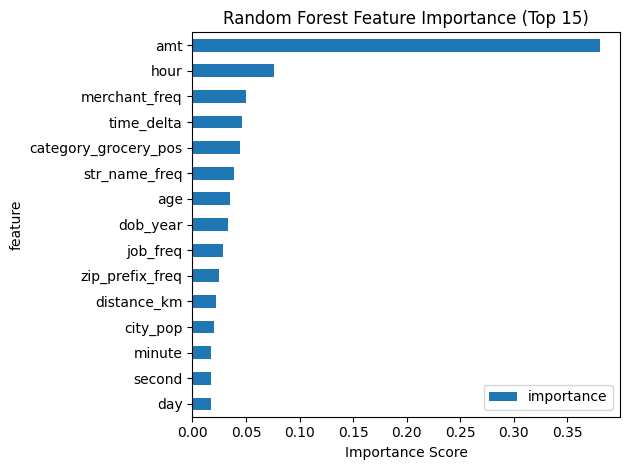


Random Forest Accuracy: 0.9985


In [ ]:
# Random Forest Feature Importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Lấy feature importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Features quan trọng nhất theo Random Forest:")
print(rf_importance.head(15))

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
rf_importance.head(15).plot(x='feature', y='importance', kind='barh')
plt.title('Random Forest Feature Importance (Top 15)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Accuracy với Random Forest
rf_pred = rf_classifier.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")

### Logistic Regression Weights (Feature Coefficients)

Top 15 Features quan trọng nhất theo Logistic Regression (theo giá trị tuyệt đối):
                   feature  coefficient  abs_coefficient
34       time_of_day_Night     1.188286         1.188286
32         category_travel    -1.032500         1.032500
23    category_grocery_pos     0.929968         0.929968
5                     hour     0.825250         0.825250
21  category_gas_transport     0.693907         0.693907
27       category_misc_net     0.547198         0.547198
30   category_shopping_net     0.464717         0.464717
0                      amt     0.417970         0.417970
22    category_grocery_net     0.397367         0.397367
8               time_delta    -0.397289         0.397289
19         zip_prefix_freq    -0.240310         0.240310
31   category_shopping_pos     0.226427         0.226427
25           category_home    -0.221704         0.221704
3                    month    -0.220147         0.220147
16           str_name_freq    -0.198772         0.198772


<Figure size 1200x800 with 0 Axes>

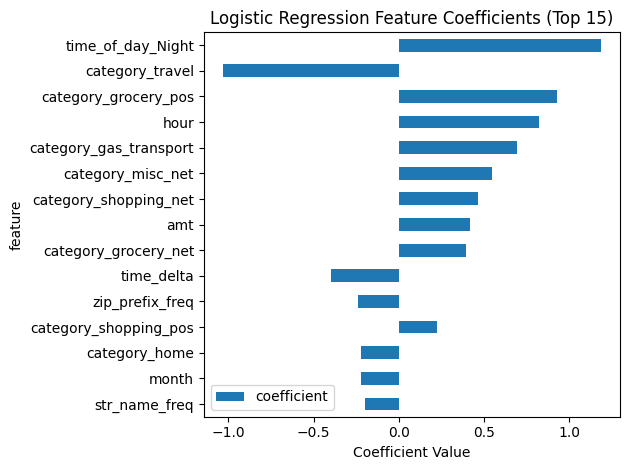


Logistic Regression Accuracy: 0.9960


In [ ]:
# Logistic Regression Feature Importance (weights/coefficients)
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train_scaled, y_train)

# Lấy coefficients (weights)
lr_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_classifier.coef_[0],
    'abs_coefficient': np.abs(lr_classifier.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 15 Features quan trọng nhất theo Logistic Regression (theo giá trị tuyệt đối):")
print(lr_importance.head(15))

# Vẽ biểu đồ coefficients
plt.figure(figsize=(12, 8))
lr_importance.head(15).plot(x='feature', y='coefficient', kind='barh')
plt.title('Logistic Regression Feature Coefficients (Top 15)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Accuracy với Logistic Regression
lr_pred = lr_classifier.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f}")

# Step 4: Train model

## Train and Evaluate Light GBM Model

### Train

#### Auto Weighting

In [ ]:
lgbm = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=15,              # ~2^max_depth, prevents overfitting
    min_child_samples=50,       # prevents tiny leaf nodes
    lambda_l1=5.0,
    lambda_l2=5.0,
    class_weight="balanced",    # handle imbalanced data
    subsample=0.7,              # row subsampling
    colsample_bytree=0.7,       # feature subsampling
    random_state=42,
)

# Train
lgbm.fit(
    X_train_lgbm, y_train_lgbm,
    eval_set=[(X_val_lgbm, y_val_lgbm)],
    eval_metric='auc',
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(stopping_rounds=50, verbose=False), log_evaluation(0)]
)

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.754351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used featu

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, lambda_l1=5.0,
               lambda_l2=5.0, learning_rate=0.05, max_depth=4,
               min_child_samples=50, n_estimators=1000, num_leaves=15,
               random_state=42, subsample=0.7)

#### Manual Weighting

In [ ]:
n = 125
weights = np.where(y_train_lgbm == 1, n, 1)

lgbm_manual = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=15,              # ~2^max_depth, prevents overfitting
    min_child_samples=50,       # prevents tiny leaf nodes
    lambda_l1=5.0,
    lambda_l2=5.0,
    subsample=0.7,              # row subsampling
    colsample_bytree=0.7,       # feature subsampling
    random_state=42,
)

# Train
lgbm_manual.fit(
    X_train_lgbm, y_train_lgbm,
    sample_weight=weights,
    eval_set=[(X_val_lgbm, y_val_lgbm)],
    eval_metric='auc',
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.790949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used featu

LGBMClassifier(colsample_bytree=0.7, lambda_l1=5.0, lambda_l2=5.0,
               learning_rate=0.05, max_depth=4, min_child_samples=50,
               n_estimators=1000, num_leaves=15, random_state=42,
               subsample=0.7)

### Evaluate

In [ ]:
X_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1037340 entries, 101339 to 866833
Data columns (total 30 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   cc_num         1037340 non-null  int64   
 1   category       1037340 non-null  category
 2   amt            1037340 non-null  float64 
 3   gender         1037340 non-null  category
 4   state          1037340 non-null  category
 5   city_pop       1037340 non-null  int64   
 6   year           1037340 non-null  int32   
 7   month          1037340 non-null  int32   
 8   day            1037340 non-null  int32   
 9   hour           1037340 non-null  int32   
 10  minute         1037340 non-null  int32   
 11  second         1037340 non-null  int32   
 12  time_of_day    1037340 non-null  category
 13  time_delta     1037340 non-null  float64 
 14  dob_year       1037340 non-null  int32   
 15  dob_month      1037340 non-null  int32   
 16  dob_day        1037340 non-null  int3

In [ ]:
X_test_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 157 to 553883
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   cc_num         555719 non-null  int64   
 1   category       555719 non-null  category
 2   amt            555719 non-null  float64 
 3   gender         555719 non-null  category
 4   state          555719 non-null  category
 5   city_pop       555719 non-null  int64   
 6   unix_time      555719 non-null  int64   
 7   year           555719 non-null  int32   
 8   month          555719 non-null  int32   
 9   day            555719 non-null  int32   
 10  hour           555719 non-null  int32   
 11  minute         555719 non-null  int32   
 12  second         555719 non-null  int32   
 13  dob_year       555719 non-null  int32   
 14  dob_month      555719 non-null  int32   
 15  dob_day        555719 non-null  int32   
 16  age            555719 non-null  int32   
 17  zip_prefix   

In [ ]:
def prec_recall_plot(y_proba, y_test=y_val_lgbm):

    # Compute precision, recall, thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # Find where |precision - recall| is minimal
    diff = np.abs(precision[:-1] - recall[:-1])
    idx = np.argmin(diff)
    best_threshold = thresholds[idx]

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")

    # Mark intersection point
    plt.scatter(
        best_threshold, precision[idx],
        color="red", zorder=5, label=f"Intersection @ {best_threshold:.2f}"
    )

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision & Recall vs Threshold")
    plt.xticks(np.arange(0, 1.00, 0.05))
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Intersection point threshold: {best_threshold:.2f}, Precision={precision[idx]:.2f}, Recall={recall[idx]:.2f}")

In [ ]:
def prec_recall_tradeoff(y_proba, y_test=y_val_lgbm):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

    # Convert to percentages
    precisions *= 100
    recalls *= 100

    # Bin precision into 5% intervals
    bins = np.arange(0, 105, 5)  # [0, 5, 10, ..., 100]
    bin_indices = np.digitize(precisions, bins) - 1

    # For each bin, take the max recall (since recall drops with more strict thresholds)
    binned_recalls = []
    binned_precisions = []

    for i in range(len(bins)-1):
        mask = bin_indices == i
        if np.any(mask):
            binned_precisions.append((bins[i] + bins[i+1]) / 2)  # midpoint of bin
            binned_recalls.append(np.max(recalls[mask]))

    # Ensure recall starts at 100%
    if binned_precisions[0] > 0:
        binned_precisions.insert(0, 0)
        binned_recalls.insert(0, 100.0)

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(binned_precisions, binned_recalls, marker='o')
    plt.xlabel("Precision (%) [5% bins]")
    plt.ylabel("Recall (%)")
    plt.title("Recall vs Precision (binned)")
    plt.ylim(0, 105)

    # Force x/y ticks every 5%
    plt.xticks(np.arange(0, 105, 5))
    plt.yticks(np.arange(0, 105, 5))

    plt.grid(True)
    plt.show()

#### Auto Weighting

In [ ]:
# Predict on validation set
y_val_pred = lgbm.predict(X_val_lgbm, num_iteration=lgbm.best_iteration_)
y_val_proba = lgbm.predict_proba(X_val_lgbm, num_iteration=lgbm.best_iteration_)[:, 1]

print("\nClassification Report:\n", classification_report(y_val_lgbm, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val_lgbm, y_val_proba))

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.59      0.96      0.73      1501

    accuracy                           1.00    259335
   macro avg       0.79      0.98      0.86    259335
weighted avg       1.00      1.00      1.00    259335

ROC AUC: 0.9989788734383257


In [ ]:
# Predict on test set
y_pred = lgbm.predict(X_test_lgbm, num_iteration=lgbm.best_iteration_)
y_proba = lgbm.predict_proba(X_test_lgbm, num_iteration=lgbm.best_iteration_)[:, 1]

print("\nClassification Report:\n", classification_report(y_test_lgbm, y_pred))
print("ROC AUC:", roc_auc_score(y_test_lgbm, y_proba))

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.56      0.71      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.78      0.86      0.81    555719
weighted avg       1.00      1.00      1.00    555719

ROC AUC: 0.9934115967069105


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


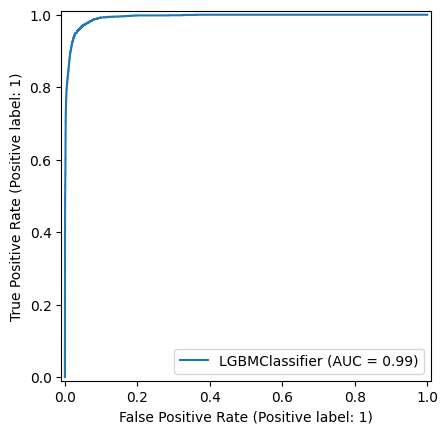

In [ ]:
# ROC Curve
RocCurveDisplay.from_estimator(lgbm, X_test_lgbm, y_test_lgbm)
plt.show()

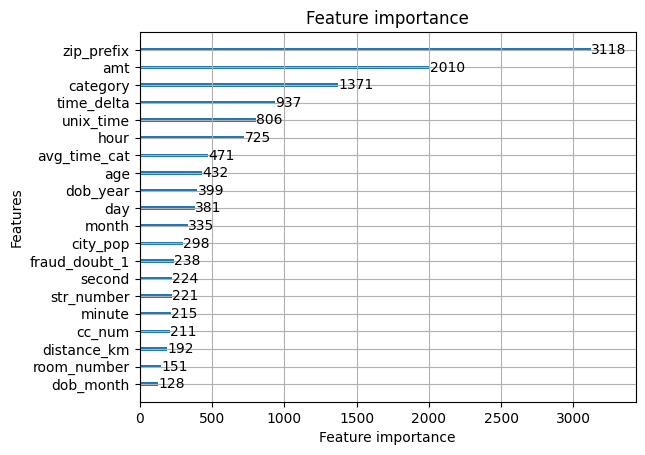

In [ ]:
# Feature importance
lgb.plot_importance(lgbm, max_num_features=20)
plt.show()

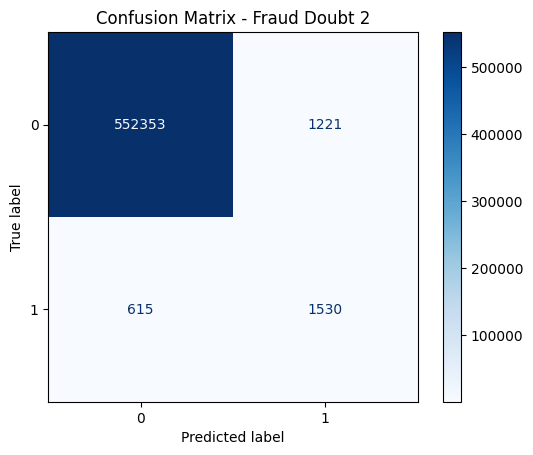

In [ ]:
cm = confusion_matrix(y_test_lgbm, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Fraud Doubt 2")
plt.show()

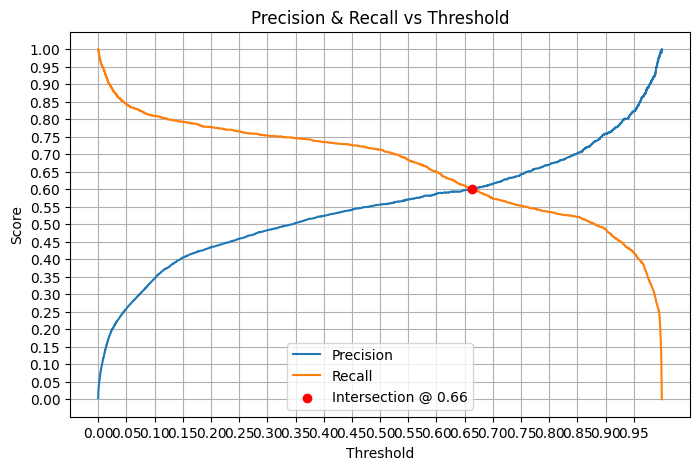

Intersection point threshold: 0.66, Precision=0.60, Recall=0.60


In [ ]:
prec_recall_plot(y_proba, y_test_lgbm)

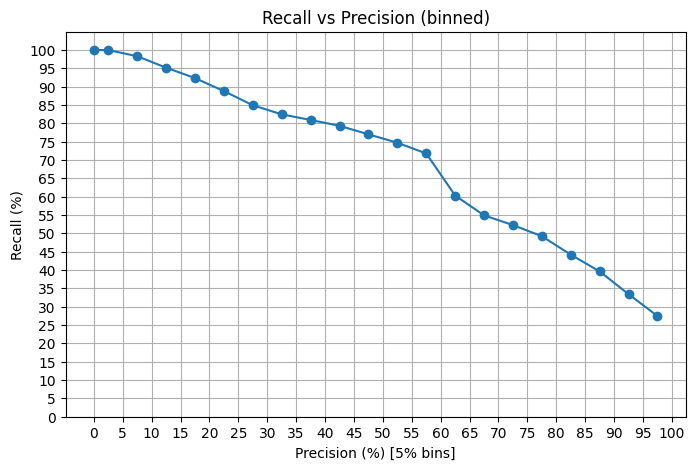

In [ ]:
prec_recall_tradeoff(y_proba, y_test_lgbm)

#### Manual Weighting

In [ ]:
# Predict on validation set
y_val_pred_manual = lgbm_manual.predict(X_val_lgbm, num_iteration=lgbm_manual.best_iteration_)
y_val_proba_manual = lgbm_manual.predict_proba(X_val_lgbm, num_iteration=lgbm_manual.best_iteration_)[:, 1]

print("\nClassification Report:\n", classification_report(y_val_lgbm, y_val_pred_manual))
print("ROC AUC:", roc_auc_score(y_val_lgbm, y_val_proba_manual))

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.63      0.96      0.76      1501

    accuracy                           1.00    259335
   macro avg       0.82      0.98      0.88    259335
weighted avg       1.00      1.00      1.00    259335

ROC AUC: 0.9989634164268199


In [ ]:
# Predict on test set
y_pred_manual = lgbm_manual.predict(X_test_lgbm, num_iteration=lgbm_manual.best_iteration_)
y_proba_manual = lgbm_manual.predict_proba(X_test_lgbm, num_iteration=lgbm_manual.best_iteration_)[:, 1]

print("\nClassification Report:\n", classification_report(y_test_lgbm, y_pred_manual))
print("ROC AUC:", roc_auc_score(y_test_lgbm, y_proba_manual))

In [ ]:
y_pred_manual = lgbm_manual.predict(X_test_lgbm, num_iteration=lgbm_manual.best_iteration_)
y_proba_manual= lgbm_manual.predict_proba(X_test_lgbm, num_iteration=lgbm_manual.best_iteration_)[:, 1]

print("\nClassification Report:\n", classification_report(y_test_lgbm, y_pred_manual))
print("ROC AUC:", roc_auc_score(y_test_lgbm, y_proba_manual))

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.50      0.71      0.59      2145

    accuracy                           1.00    555719
   macro avg       0.75      0.86      0.79    555719
weighted avg       1.00      1.00      1.00    555719

ROC AUC: 0.9926835520851858


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


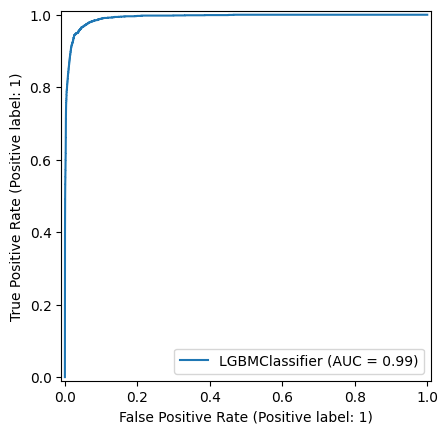

In [ ]:
# ROC Curve
RocCurveDisplay.from_estimator(lgbm_manual, X_test_lgbm, y_test_lgbm)
plt.show()

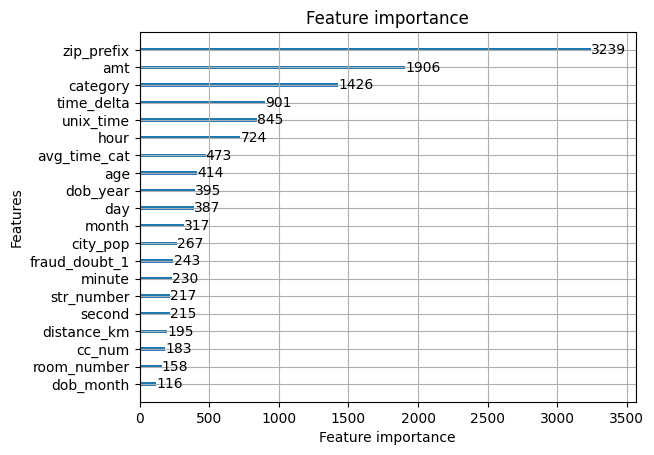

In [ ]:
# Feature importance
lgb.plot_importance(lgbm_manual, max_num_features=20)
plt.show()

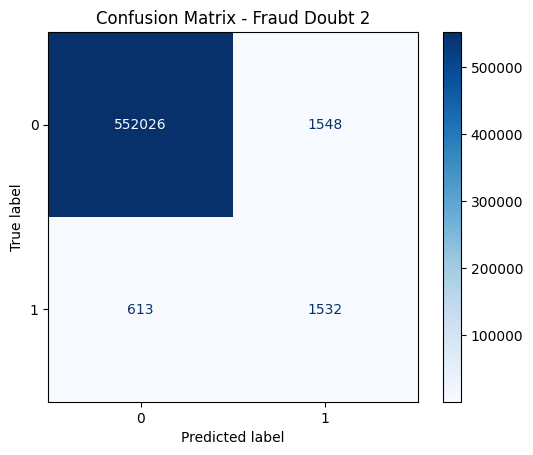

In [ ]:
cm = confusion_matrix(y_test_lgbm, y_pred_manual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Fraud Doubt 2")
plt.show()

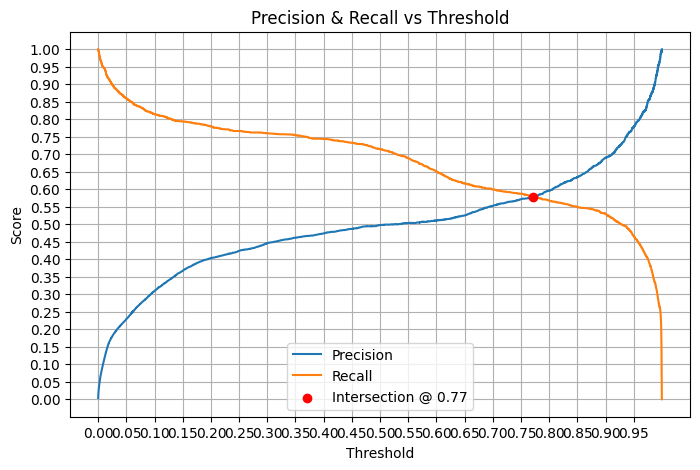

Intersection point threshold: 0.77, Precision=0.58, Recall=0.58


In [ ]:
prec_recall_plot(y_proba_manual, y_test_lgbm)

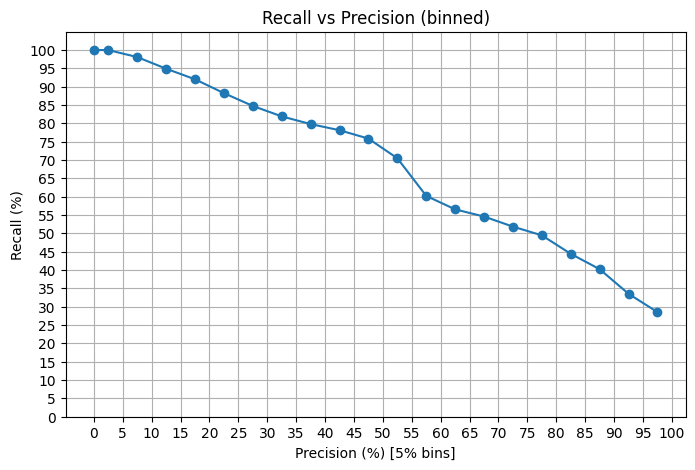

In [ ]:
prec_recall_tradeoff(y_proba_manual, y_test_lgbm)

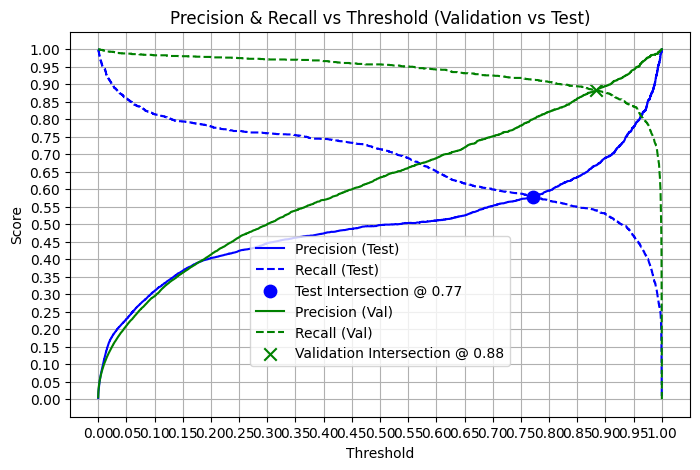

[Test]  Best threshold=0.77, Precision=0.58, Recall=0.58
[Val] Best threshold=0.88, Precision=0.88, Recall=0.88


In [ ]:
# --- Test set ---
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test_lgbm, y_proba_manual)
diff_test = np.abs(precision_test[:-1] - recall_test[:-1])
idx_test = np.argmin(diff_test)
best_threshold_test = thresholds_test[idx_test]

# --- Validation set ---
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val_lgbm, y_val_proba_manual)
diff_val = np.abs(precision_val[:-1] - recall_val[:-1])
idx_val = np.argmin(diff_val)
best_threshold_val = thresholds_val[idx_val]

# --- Plot ---
plt.figure(figsize=(8,5))

# Test curves
plt.plot(thresholds_test, precision_test[:-1], label="Precision (Test)", color="blue")
plt.plot(thresholds_test, recall_test[:-1], label="Recall (Test)", color="blue", linestyle="--")
plt.scatter(best_threshold_test, precision_test[idx_test],
            color="blue", marker="o", s=80,
            label=f"Test Intersection @ {best_threshold_test:.2f}")

# Train curves
plt.plot(thresholds_val, precision_val[:-1], label="Precision (Val)", color="green")
plt.plot(thresholds_val, recall_val[:-1], label="Recall (Val)", color="green", linestyle="--")
plt.scatter(best_threshold_val, precision_val[idx_val],
            color="green", marker="x", s=80,
            label=f"Validation Intersection @ {best_threshold_val:.2f}")

# Formatting
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (Validation vs Test)")
plt.legend()
plt.grid()

plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))

legend_loc = "center"   # examples: "upper right", "center left", "best", etc.
plt.legend(loc=legend_loc, bbox_to_anchor=(0.5, 0.3))  # bbox optional

plt.show()

# Print intersection details
print(f"[Test]  Best threshold={best_threshold_test:.2f}, Precision={precision_test[idx_test]:.2f}, Recall={recall_test[idx_test]:.2f}")
print(f"[Val] Best threshold={best_threshold_val:.2f}, Precision={precision_val[idx_val]:.2f}, Recall={recall_val[idx_val]:.2f}")


## Train and Evaluate Models on Unsampled Data

### Train

In [ ]:
#Train Logistic Regression ---
lr = LogisticRegression(
    class_weight="balanced",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
# Train RandomForest model
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Calculate scale_pos_weight
# Assuming y_train is your training target variable before resampling
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

# Train XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_value) # Added use_label_encoder and eval_metric and scale_pos_weight
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### Evaluate

#### Logistic Regression

In [ ]:
# Evaluate Logistic Regression on training data
y_pred_val_lr = lr.predict(X_val_scaled)
y_prob_val_lr = lr.predict_proba(X_val_scaled)[:, 1]

print("Logistic Regression Classification Report (Training Data):")
print(classification_report(y_val, y_pred_val_lr, digits=4))
print("Logistic Regression ROC-AUC (Training Data):", roc_auc_score(y_val, y_prob_val_lr))
print("Logistic Regression PR-AUC (Training Data):", average_precision_score(y_val, y_prob_val_lr))

Logistic Regression Classification Report (Training Data):
              precision    recall  f1-score   support

           0     0.9988    0.8823    0.9370    257653
           1     0.0386    0.8190    0.0737      1486

    accuracy                         0.8820    259139
   macro avg     0.5187    0.8507    0.5053    259139
weighted avg     0.9933    0.8820    0.9320    259139

Logistic Regression ROC-AUC (Training Data): 0.9420856415024873
Logistic Regression PR-AUC (Training Data): 0.20310285077804263


In [ ]:
# Evaluate Logistic Regression on test data
y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))

Classification report:
              precision    recall  f1-score   support

           0     0.9990    0.9224    0.9592    552670
           1     0.0358    0.7492    0.0683      2125

    accuracy                         0.9218    554795
   macro avg     0.5174    0.8358    0.5138    554795
weighted avg     0.9953    0.9218    0.9558    554795

ROC-AUC: 0.9378707455464861
PR-AUC: 0.14672556198184894


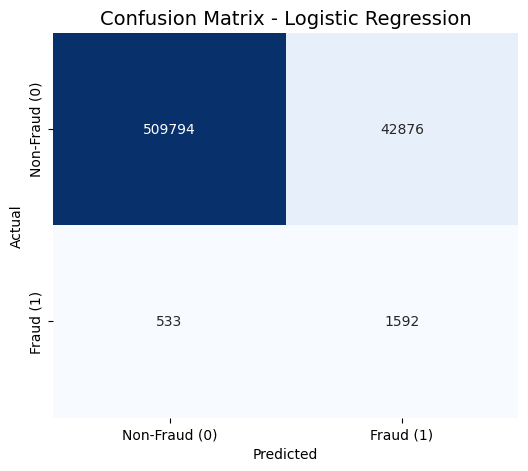

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])
plt.title("Confusion Matrix - Logistic Regression", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Random Forest

In [ ]:
# Evaluate RandomForest model on training data
y_pred_val_rf = rf.predict(X_val_scaled)
y_prob_val_rf = rf.predict_proba(X_val_scaled)[:, 1]

print("RandomForest Classification Report (Training Data):")
print(classification_report(y_val, y_pred_val_rf, digits=4))
print("RandomForest ROC-AUC (Training Data):", roc_auc_score(y_val, y_prob_val_rf))
print("RandomForest PR-AUC (Training Data):", average_precision_score(y_val, y_prob_val_rf))

RandomForest Classification Report (Training Data):
              precision    recall  f1-score   support

           0     0.9983    0.9999    0.9991    257653
           1     0.9867    0.6992    0.8184      1486

    accuracy                         0.9982    259139
   macro avg     0.9925    0.8496    0.9088    259139
weighted avg     0.9982    0.9982    0.9981    259139

RandomForest ROC-AUC (Training Data): 0.9890945143655421
RandomForest PR-AUC (Training Data): 0.9164234375394904


In [ ]:
# Evaluate RandomForest model on test data
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("RandomForest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("RandomForest PR-AUC:", average_precision_score(y_test, y_prob_rf))

RandomForest Classification Report:
              precision    recall  f1-score   support

           0     0.9987    1.0000    0.9993    552670
           1     0.9815    0.6489    0.7813      2125

    accuracy                         0.9986    554795
   macro avg     0.9901    0.8244    0.8903    554795
weighted avg     0.9986    0.9986    0.9985    554795

RandomForest ROC-AUC: 0.9840378692103255
RandomForest PR-AUC: 0.8681284936795904


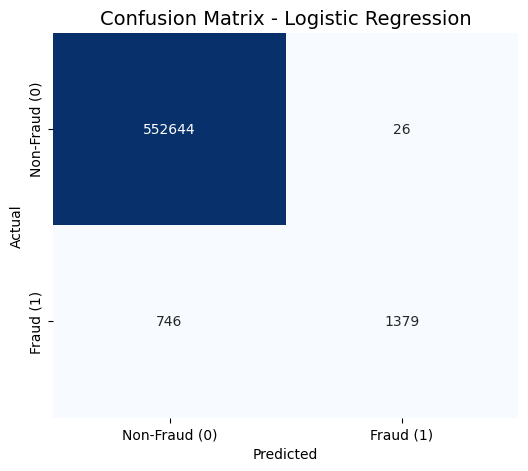

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])
plt.title("Confusion Matrix - Random Forest", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

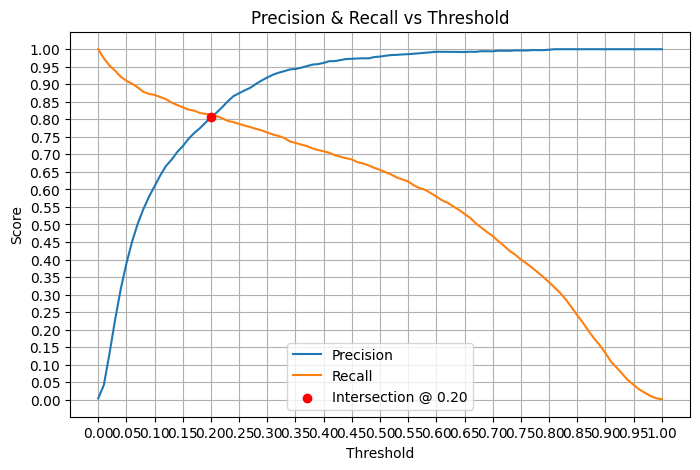

Intersection point threshold: 0.20, Precision=0.81, Recall=0.81


In [ ]:
# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf)

# Find where |precision - recall| is minimal
diff = np.abs(precision[:-1] - recall[:-1])
idx = np.argmin(diff)
best_threshold = thresholds[idx]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

# Mark intersection point
plt.scatter(
    best_threshold, precision[idx],
    color="red", zorder=5, label=f"Intersection @ {best_threshold:.2f}"
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()

# 👇 Set y-axis ticks every 0.5
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))

plt.show()

print(f"Intersection point threshold: {best_threshold:.2f}, Precision={precision[idx]:.2f}, Recall={recall[idx]:.2f}")

#### XGBoost

In [ ]:
# Evaluate XGBoost model on training data
y_pred_val_xgb = xgb.predict(X_val_scaled)
y_prob_val_xgb = xgb.predict_proba(X_val_scaled)[:, 1]

print("XGBoost Classification Report (Training Data):")
print(classification_report(y_val, y_pred_val_xgb, digits=4))
print("XGBoost ROC-AUC (Training Data):", roc_auc_score(y_val, y_prob_val_xgb))
print("XGBoost PR-AUC (Training Data):", average_precision_score(y_val, y_prob_val_xgb))

XGBoost Classification Report (Training Data):
              precision    recall  f1-score   support

           0     0.9997    0.9969    0.9983    257653
           1     0.6421    0.9549    0.7679      1486

    accuracy                         0.9967    259139
   macro avg     0.8209    0.9759    0.8831    259139
weighted avg     0.9977    0.9967    0.9970    259139

XGBoost ROC-AUC (Training Data): 0.998941999881851
XGBoost PR-AUC (Training Data): 0.9509413834537457


In [ ]:
# Evaluate XGBoost model on test data
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("XGBoost PR-AUC:", average_precision_score(y_test, y_prob_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9971    0.9984    552670
           1     0.5465    0.9064    0.6819      2125

    accuracy                         0.9968    554795
   macro avg     0.7731    0.9517    0.8401    554795
weighted avg     0.9979    0.9968    0.9972    554795

XGBoost ROC-AUC: 0.9977420104966371
XGBoost PR-AUC: 0.8940028813373779


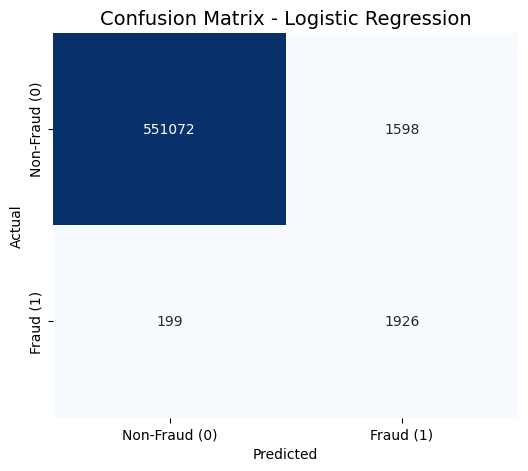

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])
plt.title("Confusion Matrix - XGBoost", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

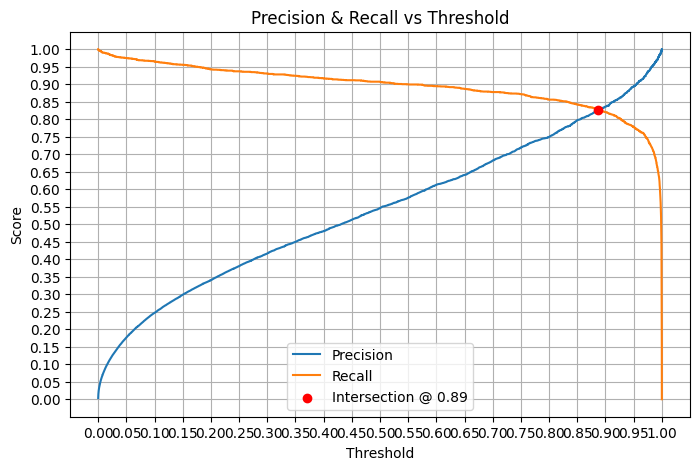

Intersection point threshold: 0.89, Precision=0.83, Recall=0.83


In [ ]:
# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Find where |precision - recall| is minimal
diff = np.abs(precision[:-1] - recall[:-1])
idx = np.argmin(diff)
best_threshold = thresholds[idx]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

# Mark intersection point
plt.scatter(
    best_threshold, precision[idx],
    color="red", zorder=5, label=f"Intersection @ {best_threshold:.2f}"
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()

# 👇 Set y-axis ticks every 0.5
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))

plt.show()

print(f"Intersection point threshold: {best_threshold:.2f}, Precision={precision[idx]:.2f}, Recall={recall[idx]:.2f}")

## Data Sampling

In [ ]:
# Define the undersampling strategy
# We want to reduce the majority class size to about half of its original size.
# The original majority class size is approximately 1,288,261.
# Half of that is around 644,130. Let's use a value around 600,000 for demonstration.
rus = RandomUnderSampler(sampling_strategy={0: 600000, 1: len(y_train[y_train == 1])}, random_state=42)

# Apply undersampling to the training data
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_scaled, y_train)

print("Shape of X_train_scaled after undersampling:", X_train_undersampled.shape)
print("Shape of y_train_scaled after undersampling:", y_train_undersampled.shape)
print("Distribution of the target variable after undersampling:")
print(pd.Series(y_train_undersampled).value_counts())

Shape of X_train_scaled after undersampling: (605945, 35)
Shape of y_train_scaled after undersampling: (605945,)
Distribution of the target variable after undersampling:
is_fraud
0    600000
1      5945
Name: count, dtype: int64


In [ ]:
# Define the SMOTE strategy
# We want to oversample the minority class (fraud) to have the same number of samples
# as the majority class after undersampling.
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the undersampled training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_undersampled, y_train_undersampled)

print("Shape of X_train_scaled after SMOTE:", X_train_resampled.shape)
print("Shape of y_train_scaled after SMOTE:", y_train_resampled.shape)
print("Distribution of the target variable after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Shape of X_train_scaled after SMOTE: (1200000, 35)
Shape of y_train_scaled after SMOTE: (1200000,)
Distribution of the target variable after SMOTE:
is_fraud
0    600000
1    600000
Name: count, dtype: int64


## Train and Evaluate Models on Resampled Data

### Train

In [ ]:
# Train Logistic Regression model on resampled data
lr_resampled = LogisticRegression(
    class_weight="balanced", # Use balanced class weight as a starting point, though SMOTE might make it less necessary
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)
lr_resampled.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
# Train RandomForest model on resampled data
rf_resampled = RandomForestClassifier(max_depth=25, random_state=42)
rf_resampled.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=25, random_state=42)

In [ ]:
# Train XGBoost model on resampled data
xgb_resampled = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_resampled.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### Evaluate

#### Logistic Regression

In [ ]:
# Evaluate Logistic Regression on training data
y_pred_val_lr_resampled = lr_resampled.predict(X_val_scaled)
y_prob_val_lr_resampled = lr_resampled.predict_proba(X_val_scaled)[:, 1]

print("Logistic Regression Classification Report (Resampled Training Data):")
print(classification_report(y_val, y_pred_val_lr_resampled, digits=4))
print("Logistic Regression ROC-AUC (Resampled Training Data):", roc_auc_score(y_val, y_prob_val_lr_resampled))
print("Logistic Regression PR-AUC (Resampled Training Data):", average_precision_score(y_val, y_prob_val_lr_resampled))

Logistic Regression Classification Report (Resampled Training Data):
              precision    recall  f1-score   support

           0     0.9989    0.8795    0.9354    257653
           1     0.0380    0.8257    0.0727      1486

    accuracy                         0.8792    259139
   macro avg     0.5184    0.8526    0.5040    259139
weighted avg     0.9933    0.8792    0.9304    259139

Logistic Regression ROC-AUC (Resampled Training Data): 0.9420420316684234
Logistic Regression PR-AUC (Resampled Training Data): 0.20451313874334912


In [ ]:
# Evaluate Logistic Regression on the original test data
y_pred_lr_resampled = lr_resampled.predict(X_test_scaled)
y_prob_lr_resampled = lr_resampled.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_lr_resampled, digits=4))
print("Logistic Regression ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_lr_resampled))
print("Logistic Regression PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_lr_resampled))

Logistic Regression Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0     0.9989    0.9314    0.9640    552670
           1     0.0398    0.7393    0.0755      2125

    accuracy                         0.9307    554795
   macro avg     0.5194    0.8353    0.5197    554795
weighted avg     0.9953    0.9307    0.9606    554795

Logistic Regression ROC-AUC (Resampled Data): 0.9370275005082278
Logistic Regression PR-AUC (Resampled Data): 0.14733444856166072


In [ ]:
feature_names = X.columns.tolist()

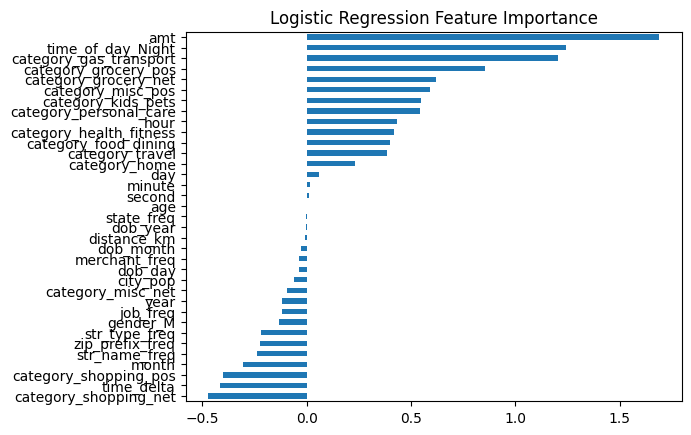

In [ ]:
coefs = lr_resampled.coef_[0]   # logistic regression coefficients
importance = pd.Series(coefs, index=feature_names)

importance.sort_values().plot(kind="barh")
plt.title("Logistic Regression Feature Importance")
plt.show()

#### Random Forest

In [ ]:
# Evaluate RandomForest model on training data
y_pred_val_rf_resampled = rf_resampled.predict(X_val_scaled)
y_prob_val_rf_resampled = rf_resampled.predict_proba(X_val_scaled)[:, 1]

print("RandomForest Classification Report (Resampled Training Data):")
print(classification_report(y_val, y_pred_val_rf_resampled, digits=4))
print("RandomForest ROC-AUC (Resampled Training Data):", roc_auc_score(y_val, y_prob_val_rf_resampled))
print("RandomForest PR-AUC (Resampled Training Data):", average_precision_score(y_val, y_prob_val_rf_resampled))

RandomForest Classification Report (Resampled Training Data):
              precision    recall  f1-score   support

           0     0.9992    0.9987    0.9989    257653
           1     0.7853    0.8540    0.8182      1486

    accuracy                         0.9978    259139
   macro avg     0.8922    0.9263    0.9085    259139
weighted avg     0.9979    0.9978    0.9979    259139

RandomForest ROC-AUC (Resampled Training Data): 0.9952989280568538
RandomForest PR-AUC (Resampled Training Data): 0.8947816859738635


In [ ]:
# Evaluate RandomForest model on the original test data
y_pred_rf_resampled = rf_resampled.predict(X_test_scaled)
y_prob_rf_resampled = rf_resampled.predict_proba(X_test_scaled)[:, 1]

print("RandomForest Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_rf_resampled, digits=4))
print("RandomForest ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_rf_resampled))
print("RandomForest PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_rf_resampled))

RandomForest Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0     0.9993    0.9988    0.9991    552670
           1     0.7275    0.8165    0.7694      2125

    accuracy                         0.9981    554795
   macro avg     0.8634    0.9076    0.8842    554795
weighted avg     0.9983    0.9981    0.9982    554795

RandomForest ROC-AUC (Resampled Data): 0.9936282521534499
RandomForest PR-AUC (Resampled Data): 0.8401299753600594


Top 20 most important features:
                   feature  importance
0                      amt    0.426066
5                     hour    0.141687
34       time_of_day_Night    0.137833
14           merchant_freq    0.036707
8               time_delta    0.031435
21  category_gas_transport    0.018491
30   category_shopping_net    0.015866
33                gender_M    0.013978
3                    month    0.013680
23    category_grocery_pos    0.013578
16           str_name_freq    0.012086
9                 dob_year    0.011126
12                     age    0.010448
19         zip_prefix_freq    0.008977
10               dob_month    0.007878
25           category_home    0.007565
1                 city_pop    0.007477
17           str_type_freq    0.007403
27       category_misc_net    0.007268
18                job_freq    0.007085


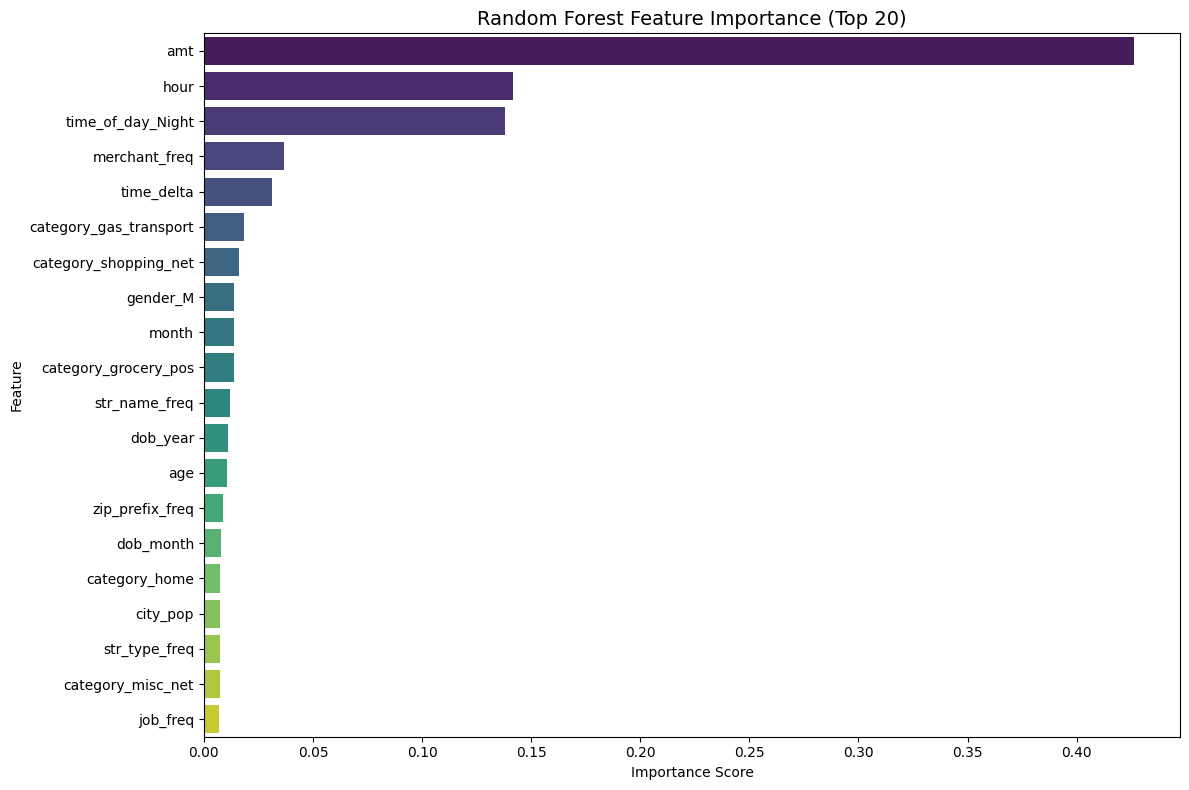

In [ ]:
# Get feature importances
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_resampled.feature_importances_
}).sort_values('importance', ascending=False)

# Show top 20
print("Top 20 most important features:")
print(rf_importance.head(20))

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=rf_importance.head(20),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title('Random Forest Feature Importance (Top 20)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

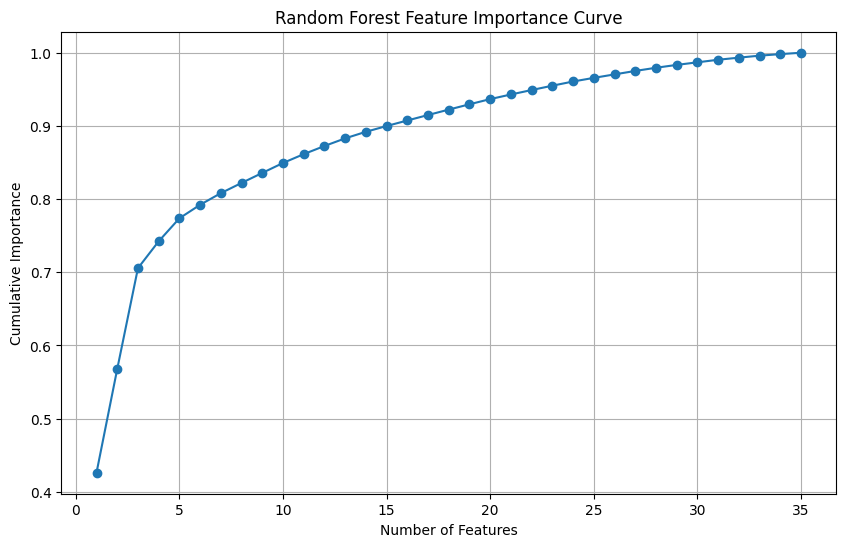

90% of importance is explained by top 16 features
95% of importance is explained by top 23 features
99% of importance is explained by top 31 features


In [ ]:
# Sort features by importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_resampled.feature_importances_
}).sort_values('importance', ascending=False)

# Compute cumulative importance
rf_importance['cumulative_importance'] = np.cumsum(rf_importance['importance'])

# Plot feature importance curve
plt.figure(figsize=(10,6))
plt.plot(range(1, len(rf_importance)+1), rf_importance['cumulative_importance'], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("Random Forest Feature Importance Curve")
plt.grid(True)
plt.show()

# Optionally: show number of features explaining 90%, 95%, 99%
for threshold in [0.90, 0.95, 0.99]:
    n_features = np.argmax(rf_importance['cumulative_importance'] >= threshold) + 1
    print(f"{threshold*100:.0f}% of importance is explained by top {n_features} features")

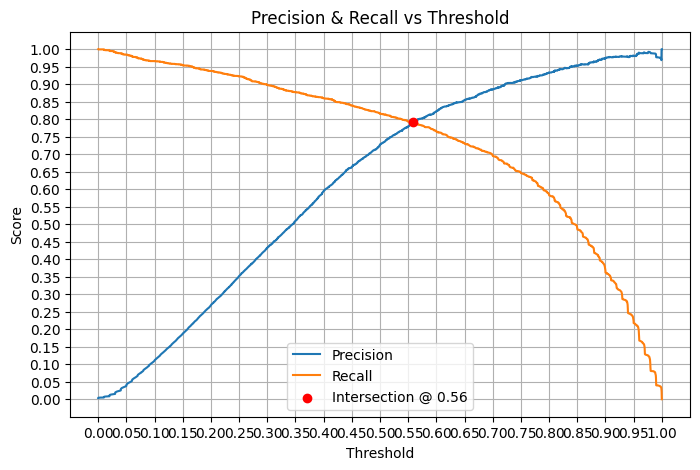

Intersection point threshold: 0.56, Precision=0.79, Recall=0.79


In [ ]:
# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf_resampled)

# Find where |precision - recall| is minimal
diff = np.abs(precision[:-1] - recall[:-1])
idx = np.argmin(diff)
best_threshold = thresholds[idx]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

# Mark intersection point
plt.scatter(
    best_threshold, precision[idx],
    color="red", zorder=5, label=f"Intersection @ {best_threshold:.2f}"
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()

# 👇 Set y-axis ticks every 0.5
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))

plt.show()

print(f"Intersection point threshold: {best_threshold:.2f}, Precision={precision[idx]:.2f}, Recall={recall[idx]:.2f}")

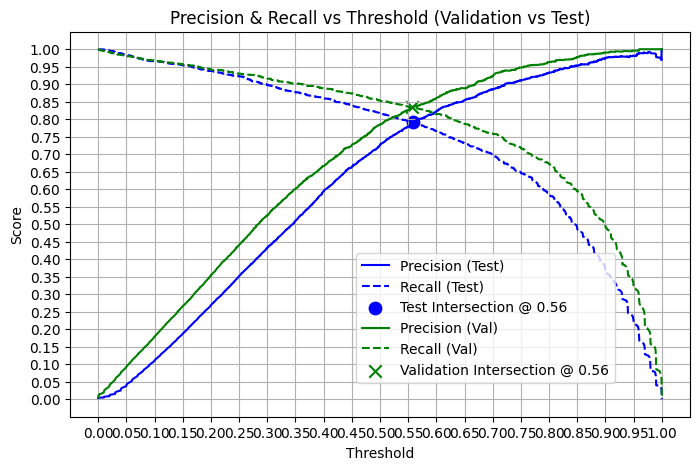

[Test]  Best threshold=0.56, Precision=0.79, Recall=0.79
[Val] Best threshold=0.56, Precision=0.83, Recall=0.83


In [ ]:
# --- Test set ---
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_prob_rf_resampled)
diff_test = np.abs(precision_test[:-1] - recall_test[:-1])
idx_test = np.argmin(diff_test)
best_threshold_test = thresholds_test[idx_test]

# --- Validation set ---
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_prob_val_rf_resampled)
diff_val = np.abs(precision_val[:-1] - recall_val[:-1])
idx_val = np.argmin(diff_val)
best_threshold_val = thresholds_val[idx_val]

# --- Plot ---
plt.figure(figsize=(8,5))

# Test curves
plt.plot(thresholds_test, precision_test[:-1], label="Precision (Test)", color="blue")
plt.plot(thresholds_test, recall_test[:-1], label="Recall (Test)", color="blue", linestyle="--")
plt.scatter(best_threshold_test, precision_test[idx_test],
            color="blue", marker="o", s=80,
            label=f"Test Intersection @ {best_threshold_test:.2f}")

# Train curves
plt.plot(thresholds_val, precision_val[:-1], label="Precision (Val)", color="green")
plt.plot(thresholds_val, recall_val[:-1], label="Recall (Val)", color="green", linestyle="--")
plt.scatter(best_threshold_val, precision_val[idx_val],
            color="green", marker="x", s=80,
            label=f"Validation Intersection @ {best_threshold_val:.2f}")

# Formatting
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (Validation vs Test)")
plt.legend()
plt.grid()

plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))

legend_loc = "lower left"   # examples: "upper right", "center left", "best", etc.
plt.legend(loc=legend_loc, bbox_to_anchor=(0.45, 0.07))  # bbox optional

plt.show()

# Print intersection details
print(f"[Test]  Best threshold={best_threshold_test:.2f}, Precision={precision_test[idx_test]:.2f}, Recall={recall_test[idx_test]:.2f}")
print(f"[Val] Best threshold={best_threshold_val:.2f}, Precision={precision_val[idx_val]:.2f}, Recall={recall_val[idx_val]:.2f}")


#### XGBoost

In [ ]:
# Evaluate XGBoost model on training data
y_pred_val_xgb_resampled = xgb_resampled.predict(X_val_scaled)
y_prob_val_xgb_resampled = xgb_resampled.predict_proba(X_val_scaled)[:, 1]

print("XGBoost Classification Report (Resampled Training Data):")
print(classification_report(y_val, y_pred_val_xgb_resampled, digits=4))
print("XGBoost ROC-AUC (Resampled Training Data):", roc_auc_score(y_val, y_prob_val_xgb_resampled))
print("XGBoost PR-AUC (Resampled Training Data):", average_precision_score(y_val, y_prob_val_xgb_resampled))

XGBoost Classification Report (Resampled Training Data):
              precision    recall  f1-score   support

           0     0.9994    0.9989    0.9992    257653
           1     0.8289    0.8930    0.8597      1486

    accuracy                         0.9983    259139
   macro avg     0.9141    0.9460    0.9294    259139
weighted avg     0.9984    0.9983    0.9984    259139

XGBoost ROC-AUC (Resampled Training Data): 0.9985279924543417
XGBoost PR-AUC (Resampled Training Data): 0.9342551955623366


In [ ]:
# Evaluate XGBoost model on the original test data
y_pred_xgb_resampled = xgb_resampled.predict(X_test_scaled)
y_prob_xgb_resampled = xgb_resampled.predict_proba(X_test_scaled)[:, 1]

print("XGBoost Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_xgb_resampled, digits=4))
print("XGBoost ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_xgb_resampled))
print("XGBoost PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_xgb_resampled))

XGBoost Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0     0.9992    0.9992    0.9992    552670
           1     0.8009    0.8047    0.8028      2125

    accuracy                         0.9985    554795
   macro avg     0.9001    0.9020    0.9010    554795
weighted avg     0.9985    0.9985    0.9985    554795

XGBoost ROC-AUC (Resampled Data): 0.9966753933578064
XGBoost PR-AUC (Resampled Data): 0.8726035431524001


<Figure size 1200x800 with 0 Axes>

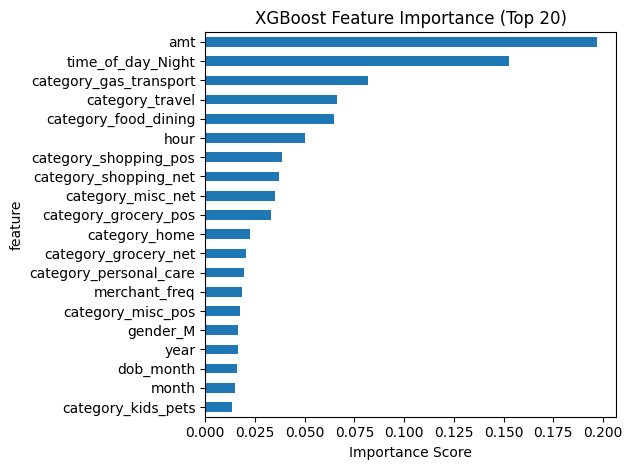

In [ ]:
# Get feature importances from XGBoost
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_resampled.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15
plt.figure(figsize=(12,8))
xgb_importance.head(20).plot(x='feature', y='importance', kind='barh', legend=False)
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

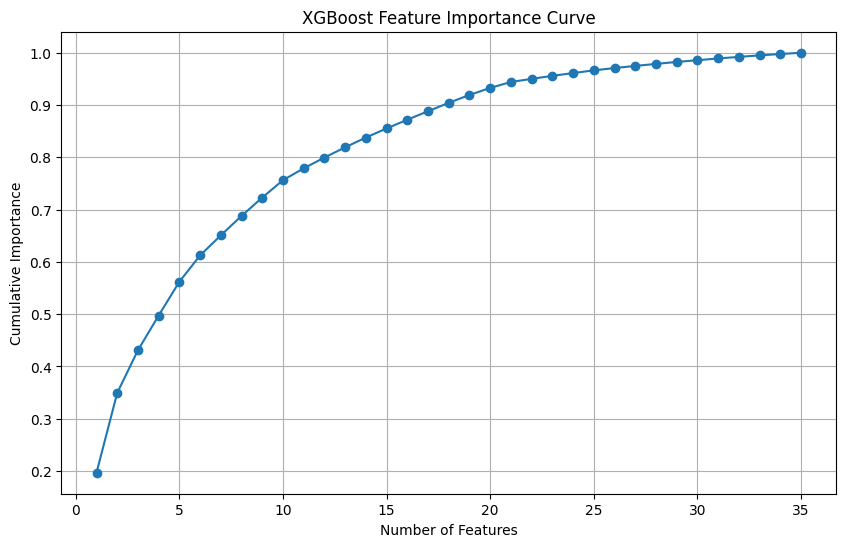

85% of importance is explained by top 15 features
90% of importance is explained by top 18 features
95% of importance is explained by top 22 features
99% of importance is explained by top 32 features


In [ ]:
# Compute cumulative importance
xgb_importance['cumulative_importance'] = np.cumsum(xgb_importance['importance'])

# Plot cumulative curve
plt.figure(figsize=(10,6))
plt.plot(range(1, len(xgb_importance)+1), xgb_importance['cumulative_importance'], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("XGBoost Feature Importance Curve")
plt.grid(True)
plt.show()

# Print how many features explain 90%, 95%, 99%
for threshold in [0.85, 0.90, 0.95, 0.99]:
    n_features = np.argmax(xgb_importance['cumulative_importance'] >= threshold) + 1
    print(f"{threshold*100:.0f}% of importance is explained by top {n_features} features")


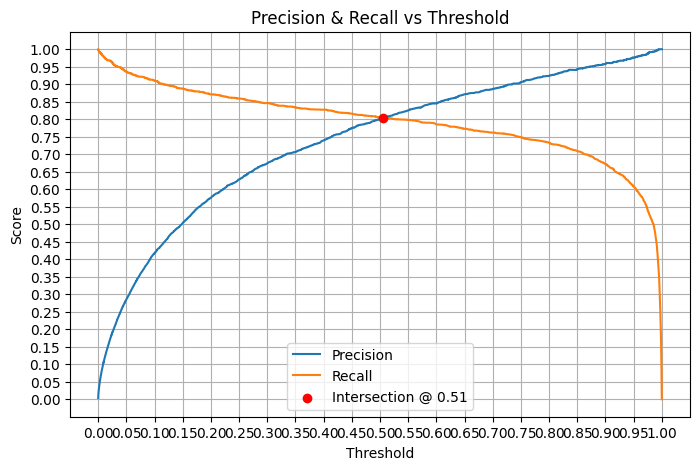

Intersection point threshold: 0.51, Precision=0.80, Recall=0.80


In [ ]:
# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb_resampled)

# Find where |precision - recall| is minimal
diff = np.abs(precision[:-1] - recall[:-1])
idx = np.argmin(diff)
best_threshold = thresholds[idx]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

# Mark intersection point
plt.scatter(
    best_threshold, precision[idx],
    color="red", zorder=5, label=f"Intersection @ {best_threshold:.2f}"
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()

# 👇 Set y-axis ticks every 0.5
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))

plt.show()

print(f"Intersection point threshold: {best_threshold:.2f}, Precision={precision[idx]:.2f}, Recall={recall[idx]:.2f}")

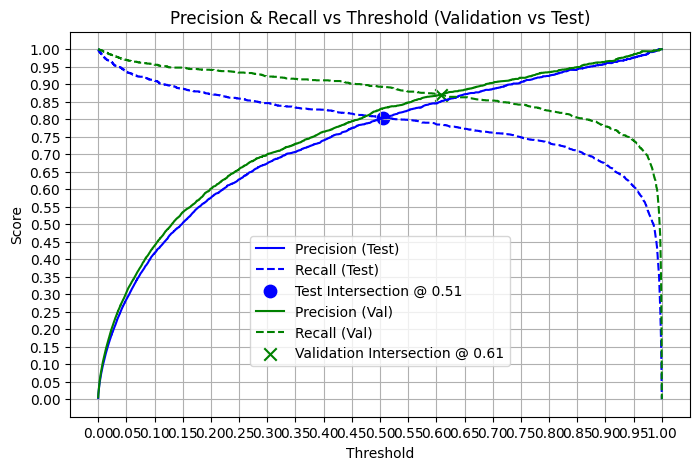

[Test]  Best threshold=0.51, Precision=0.80, Recall=0.80
[Val] Best threshold=0.61, Precision=0.87, Recall=0.87


In [ ]:
# --- Test set ---
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_prob_xgb_resampled)
diff_test = np.abs(precision_test[:-1] - recall_test[:-1])
idx_test = np.argmin(diff_test)
best_threshold_test = thresholds_test[idx_test]

# --- Validation set ---
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_prob_val_xgb_resampled)
diff_val = np.abs(precision_val[:-1] - recall_val[:-1])
idx_val = np.argmin(diff_val)
best_threshold_val = thresholds_val[idx_val]

# --- Plot ---
plt.figure(figsize=(8,5))

# Test curves
plt.plot(thresholds_test, precision_test[:-1], label="Precision (Test)", color="blue")
plt.plot(thresholds_test, recall_test[:-1], label="Recall (Test)", color="blue", linestyle="--")
plt.scatter(best_threshold_test, precision_test[idx_test],
            color="blue", marker="o", s=80,
            label=f"Test Intersection @ {best_threshold_test:.2f}")

# Train curves
plt.plot(thresholds_val, precision_val[:-1], label="Precision (Val)", color="green")
plt.plot(thresholds_val, recall_val[:-1], label="Recall (Val)", color="green", linestyle="--")
plt.scatter(best_threshold_val, precision_val[idx_val],
            color="green", marker="x", s=80,
            label=f"Validation Intersection @ {best_threshold_val:.2f}")

# Formatting
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (Validation vs Test)")
plt.legend()
plt.grid()

plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))

legend_loc = "center"   # examples: "upper right", "center left", "best", etc.
plt.legend(loc=legend_loc, bbox_to_anchor=(0.5, 0.3))  # bbox optional

plt.show()

# Print intersection details
print(f"[Test]  Best threshold={best_threshold_test:.2f}, Precision={precision_test[idx_test]:.2f}, Recall={recall_test[idx_test]:.2f}")
print(f"[Val] Best threshold={best_threshold_val:.2f}, Precision={precision_val[idx_val]:.2f}, Recall={recall_val[idx_val]:.2f}")


# Summary

In [ ]:
def compare_model_results(y_test, predictions, probabilities=None, decimals=3):
    """
    predictions: dict {"ModelName": y_pred_array, ...}
    probabilities: dict {"ModelName": y_prob_array, ...}  (optional, for roc/pr auc)
    """
    rows = []

    for name, y_pred in predictions.items():
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        metrics = {
            "precision_0": report["0"]["precision"],
            "recall_0": report["0"]["recall"],
            "precision_1": report["1"]["precision"],
            "recall_1": report["1"]["recall"],
        }

        if probabilities and name in probabilities:
            y_prob = probabilities[name]
            metrics["roc_auc"] = roc_auc_score(y_test, y_prob)
            metrics["pr_auc"] = average_precision_score(y_test, y_prob)

        rows.append((name, metrics))

    # convert to DataFrame (models as rows, metrics as cols)
    df = pd.DataFrame({name: m for name, m in rows}).T
    return df.round(decimals)

# Example usage:
predictions = {
    "LogisticReg": y_pred_lr_resampled,
    "RandomForest": y_pred_rf_resampled,
    "XGBoost": y_pred_xgb_resampled
}
probabilities = {
    "LogisticReg": y_prob_lr_resampled,
    "RandomForest": y_prob_rf_resampled,
    "XGBoost": y_prob_xgb_resampled
}

results_df = compare_model_results(y_test, predictions, probabilities)
results_df

,precision_0,recall_0,precision_1,recall_1,roc_auc,pr_auc
LogisticReg,0.999,0.931,0.040,0.739,0.937,0.147
RandomForest,0.999,0.999,0.727,0.816,0.994,0.840
XGBoost,0.999,0.999,0.801,0.805,0.997,0.873
